In [2]:
# Import libs
import importlib_resources
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, hist, show, subplot, xlabel, ylim
from matplotlib.pyplot import boxplot, plot, show, title, xticks, yticks, ylabel, suptitle
from scipy.linalg import svd

In [3]:
# Load data from the file
filepath = "prostate/"
filename = "prostate.data.txt"
doc = pd.read_csv(filename, delimiter="\t")

# Drop number, svi, pgg45, train
doc = doc.drop(doc.columns[[0, 5, 8, 10]], axis=1)
# print(doc.head(), '\n')

# Extract attribute names 
attributeNames = doc.columns[[0, 1, 2, 3, 4, 6]].tolist()
print("Attribute Names:", attributeNames, '\n')

# Convert the DataFrame to a NumPy array
data = doc.to_numpy()
X = data[:, [0, 1, 2, 3, 4, 6]]  # Feature matrix
y = data[:, 5]   # Target vector

# Compute values of N, M.
N = len(X)
M = len(attributeNames)

Attribute Names: ['lcavol', 'lweight', 'age', 'lbph', 'lcp', 'lpsa'] 



[1.00000000e-03 1.25892541e-03 1.58489319e-03 1.99526231e-03
 2.51188643e-03 3.16227766e-03 3.98107171e-03 5.01187234e-03
 6.30957344e-03 7.94328235e-03 1.00000000e-02 1.25892541e-02
 1.58489319e-02 1.99526231e-02 2.51188643e-02 3.16227766e-02
 3.98107171e-02 5.01187234e-02 6.30957344e-02 7.94328235e-02
 1.00000000e-01 1.25892541e-01 1.58489319e-01 1.99526231e-01
 2.51188643e-01 3.16227766e-01 3.98107171e-01 5.01187234e-01
 6.30957344e-01 7.94328235e-01 1.00000000e+00 1.25892541e+00
 1.58489319e+00 1.99526231e+00 2.51188643e+00 3.16227766e+00
 3.98107171e+00 5.01187234e+00 6.30957344e+00 7.94328235e+00
 1.00000000e+01 1.25892541e+01 1.58489319e+01 1.99526231e+01
 2.51188643e+01 3.16227766e+01 3.98107171e+01 5.01187234e+01
 6.30957344e+01 7.94328235e+01 1.00000000e+02 1.25892541e+02
 1.58489319e+02 1.99526231e+02 2.51188643e+02 3.16227766e+02
 3.98107171e+02 5.01187234e+02 6.30957344e+02 7.94328235e+02]

Best lambda: 12.589254117941778


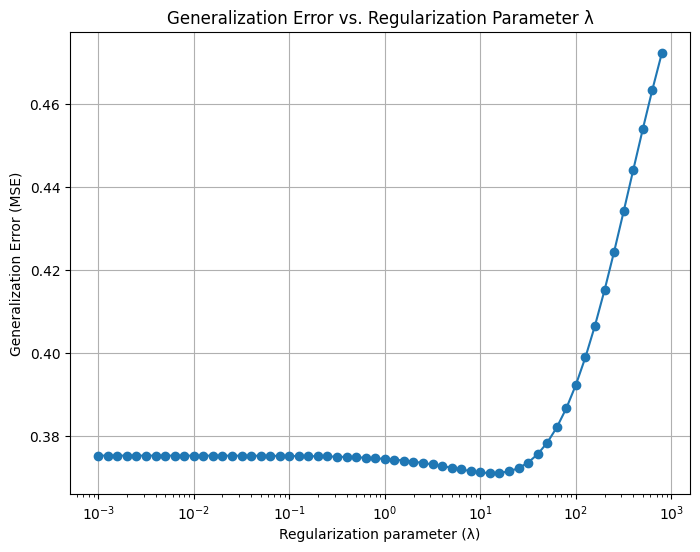

In [10]:
# Regression, part a: 1 & 2

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# lambdas = np.power(10.0, np.arange(0, 2, 0.1))
lambdas = np.power(10.0, np.arange(-3, 3, 0.1))

print(lambdas)

# Set up cross-validation
K = 10
cv = KFold(n_splits=K, shuffle=True, random_state=1)

# Initialize list to store the generalization error for each λ
generalization_errors = []

# Loop over λ values
for lambda_val in lambdas:
    # Initialize list to store the error for each fold
    fold_errors = []
    
    for train_index, test_index in cv.split(X):
        # Split data into training and test sets for the current fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardize features based on training set
        mean, std = X_train.mean(axis=0), X_train.std(axis=0)
        X_train = (X_train - mean) / std
        X_test = (X_test - mean) / std

        # Train Ridge regression model with current λ
        model = Ridge(alpha=lambda_val)
        model.fit(X_train, y_train)

        # Calculate mean squared error on the test set manually
        y_pred = model.predict(X_test)
        mse = np.mean((y_test - y_pred) ** 2)
        fold_errors.append(mse)

    # Average error across folds and store the result
    generalization_errors.append(np.mean(fold_errors))

best_lambda = lambdas[np.argmin(generalization_errors)]
print(f"\nBest lambda: {best_lambda}")

# Plot generalization error as a function of λ
plt.figure(figsize=(8, 6))
plt.plot(lambdas, generalization_errors, marker='o')
plt.xscale('log')
plt.xlabel("Regularization parameter (λ)")
plt.ylabel("Generalization Error (MSE)")
plt.title("Generalization Error vs. Regularization Parameter λ")
plt.grid(True)
plt.show()


In [5]:
# Regression, part a: 3

# Retrain the model on the entire dataset with the best lambda and print weights
final_model = Ridge(alpha=best_lambda)
final_model.fit(X, y)
print("Weights for the final model with the best lambda:")
for name, weight in zip(attributeNames, final_model.coef_):
    print(f"{name}: {weight}")

Weights for the final model with the best lambda:
lcavol: 0.04886594207842437
lweight: -0.16802368320363043
age: 0.02037783352210934
lbph: 0.014768421172422778
lcp: 0.19460315724509317
lpsa: 0.061412521037857375


In [6]:
# Import libraries
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from dtuimldmtools import train_neural_net

# Load and preprocess data
filepath = "prostate/"
filename = "prostate.data.txt"
doc = pd.read_csv(filename, delimiter="\t")
doc = doc.drop(doc.columns[[0, 5, 8, 10]], axis=1)
attributeNames = doc.columns[[0, 1, 2, 3, 4, 6]].tolist()
data = doc.to_numpy()
X = data[:, [0, 1, 2, 3, 4, 6]]
y = data[:, 5]

# Define parameters for cross-validation
K1 = 10
K2 = 10
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=1)
lambdas = np.power(10.0, np.arange(0, 2, 0.1))
hidden_units_options = [1, 2, 3]  # Different hidden layer sizes for ANN
max_iter = 10000

# Initialize error storage lists
baseline_errors = []
ridge_errors = []
ann_errors = []
best_lambdas = []
best_hidden_units_list = []

# Outer cross-validation loop
for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), start=1):
    print(f"\nStarting Outer Fold {outer_fold}/{K1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Baseline model: mean prediction
    baseline_pred = np.mean(y_train) * np.ones_like(y_test)
    baseline_error = np.mean((y_test - baseline_pred) ** 2)
    baseline_errors.append(baseline_error)
    print(f"Baseline model error for Outer Fold {outer_fold}: {baseline_error}")

    # Inner cross-validation for Ridge regression and ANN hyperparameter tuning
    inner_cv = KFold(n_splits=K2, shuffle=True, random_state=1)
    best_ridge_error = float('inf')
    best_ann_error = float('inf')
    best_lambda = None
    best_hidden_units = None

    # Ridge regression hyperparameter tuning
    print(f"\n-- Testing Ridge Regression on Outer Fold {outer_fold} --")
    for lambda_val in lambdas:
        ridge_errors_inner = []
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train), start=1):
            print(f"  Inner Fold {inner_fold}/{K2} - Ridge with λ={lambda_val}")
            X_inner_train, X_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[inner_val_idx]

            # Standardize data
            mean, std = X_inner_train.mean(axis=0), X_inner_train.std(axis=0)
            X_inner_train_std = (X_inner_train - mean) / std
            X_val_std = (X_val - mean) / std

            # Train Ridge regression model
            model = Ridge(alpha=lambda_val)
            model.fit(X_inner_train_std, y_inner_train)
            y_pred = model.predict(X_val_std)
            ridge_errors_inner.append(np.mean((y_val - y_pred) ** 2))

        avg_ridge_error = np.mean(ridge_errors_inner)
        print(f"  Avg Ridge Error for λ={lambda_val} on Outer Fold {outer_fold}: {avg_ridge_error}")

        if avg_ridge_error < best_ridge_error:
            best_ridge_error = avg_ridge_error
            best_lambda = lambda_val

    print(f"Best λ for Ridge on Outer Fold {outer_fold}: {best_lambda} with Error: {best_ridge_error}")

    # Train final Ridge model with best lambda on the full outer training set
    mean, std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train_std = (X_train - mean) / std
    X_test_std = (X_test - mean) / std
    ridge_model = Ridge(alpha=best_lambda)
    ridge_model.fit(X_train_std, y_train)
    y_pred_ridge = ridge_model.predict(X_test_std)
    ridge_errors.append(np.mean((y_test - y_pred_ridge) ** 2))
    print(f"Ridge Regression error on Outer Test Set for Fold {outer_fold}: {ridge_errors[-1]}")

    # ANN hyperparameter tuning
    print(f"\n-- Testing ANN on Outer Fold {outer_fold} --")
    for n_hidden_units in hidden_units_options:
        ann_errors_inner = []
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train), start=1):
            print(f"  Inner Fold {inner_fold}/{K2} - ANN with {n_hidden_units} Hidden Units - Outer Fold {outer_fold}")
            X_inner_train, X_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[inner_val_idx]

            # Standardize data
            mean, std = X_inner_train.mean(axis=0), X_inner_train.std(axis=0)
            X_inner_train_std = (X_inner_train - mean) / std
            X_val_std = (X_val - mean) / std

            # Convert data to torch tensors and reshape targets
            X_inner_train_tensor = torch.Tensor(X_inner_train_std)
            y_inner_train_tensor = torch.Tensor(y_inner_train).view(-1, 1)
            X_val_tensor = torch.Tensor(X_val_std)
            y_val_tensor = torch.Tensor(y_val).view(-1, 1)

            # Define the ANN model
            model = lambda: torch.nn.Sequential(
                torch.nn.Linear(X.shape[1], n_hidden_units),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden_units, 1)
            )
            loss_fn = torch.nn.MSELoss()

            # Train ANN
            net, _, _ = train_neural_net(
                model,
                loss_fn,
                X=X_inner_train_tensor,
                y=y_inner_train_tensor,
                n_replicates=1,
                max_iter=max_iter
            )

            # Validate on inner validation set
            y_val_est = net(X_val_tensor)
            mse = ((y_val_est - y_val_tensor) ** 2).mean().item()
            ann_errors_inner.append(mse)

        avg_ann_error = np.mean(ann_errors_inner)
        print(f"  Avg ANN Error for {n_hidden_units} Hidden Units on Outer Fold {outer_fold}: {avg_ann_error}")

        if avg_ann_error < best_ann_error:
            best_ann_error = avg_ann_error
            best_hidden_units = n_hidden_units

    print(f"Best ANN Hidden Units for Outer Fold {outer_fold}: {best_hidden_units} with Error: {best_ann_error}")

    # Train final ANN model with best hidden layer size on the full outer training set
    X_train_tensor = torch.Tensor(X_train_std)
    y_train_tensor = torch.Tensor(y_train).view(-1, 1)
    X_test_tensor = torch.Tensor(X_test_std)
    y_test_tensor = torch.Tensor(y_test).view(-1, 1)

    final_ann_model = lambda: torch.nn.Sequential(
        torch.nn.Linear(X.shape[1], best_hidden_units),
        torch.nn.Tanh(),
        torch.nn.Linear(best_hidden_units, 1)
    )
    net, _, _ = train_neural_net(
        final_ann_model,
        loss_fn,
        X=X_train_tensor,
        y=y_train_tensor,
        n_replicates=1,
        max_iter=max_iter
    )

    # Evaluate ANN on outer test set
    y_test_est = net(X_test_tensor)
    ann_error = ((y_test_est - y_test_tensor) ** 2).mean().item()
    ann_errors.append(ann_error)
    print(f"ANN error on Outer Test Set for Fold {outer_fold}: {ann_error}")

    # Store best lambda and hidden units
    best_lambdas.append(best_lambda)
    best_hidden_units_list.append(best_hidden_units)

# Print results
print("\nFinal Results:")
print("Baseline model errors:", baseline_errors)
print("Average Baseline model error:", np.mean(baseline_errors))

print("Ridge regression model errors:", ridge_errors)
print("Average Ridge regression model error:", np.mean(ridge_errors))

print("ANN model errors:", ann_errors)
print("Average ANN model error:", np.mean(ann_errors))

# Print detailed report
print("\nDetailed Report:")
for fold in range(K1):
    print(f"Fold {fold + 1}:")
    print(f"  Baseline Error: {baseline_errors[fold]}")
    print(f"  Ridge Regression - Best λ: {best_lambdas[fold]}, Error: {ridge_errors[fold]}")
    print(f"  ANN - Best Hidden Units: {best_hidden_units_list[fold]}, Error: {ann_errors[fold]}")




Starting Outer Fold 1/10
Baseline model error for Outer Fold 1: 0.268939093671555

-- Testing Ridge Regression on Outer Fold 1 --
  Inner Fold 1/10 - Ridge with λ=1.0
  Inner Fold 2/10 - Ridge with λ=1.0
  Inner Fold 3/10 - Ridge with λ=1.0
  Inner Fold 4/10 - Ridge with λ=1.0
  Inner Fold 5/10 - Ridge with λ=1.0
  Inner Fold 6/10 - Ridge with λ=1.0
  Inner Fold 7/10 - Ridge with λ=1.0
  Inner Fold 8/10 - Ridge with λ=1.0
  Inner Fold 9/10 - Ridge with λ=1.0
  Inner Fold 10/10 - Ridge with λ=1.0
  Avg Ridge Error for λ=1.0 on Outer Fold 1: 0.40512169199489734
  Inner Fold 1/10 - Ridge with λ=1.2589254117941673
  Inner Fold 2/10 - Ridge with λ=1.2589254117941673
  Inner Fold 3/10 - Ridge with λ=1.2589254117941673
  Inner Fold 4/10 - Ridge with λ=1.2589254117941673
  Inner Fold 5/10 - Ridge with λ=1.2589254117941673
  Inner Fold 6/10 - Ridge with λ=1.2589254117941673
  Inner Fold 7/10 - Ridge with λ=1.2589254117941673
  Inner Fold 8/10 - Ridge with λ=1.2589254117941673
  Inner Fold 9/10

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:142: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	22.524612	0.0015973585
		2000	4.274818	0.0014336453
		3000	1.0139655	0.0013436336
		4000	0.39274305	0.0005061834
		5000	0.30927363	8.238299e-05
		6000	0.3001237	4.964982e-06
		7000	0.2992676	2.688766e-06
		8000	0.29824728	3.996979e-06
		9000	0.2967241	6.126669e-06
		10000	0.29485586	6.3676343e-06
		Final loss:
		10000	0.29485586	6.3676343e-06
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 1

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	23.4088	0.0009166236
		2000	9.080027	0.0010118835
		3000	2.9779437	0.0012142573
		4000	0.88992643	0.0010788398
		5000	0.41616547	0.0004253358
		6000	0.33951947	5.8105627e-05
		7000	0.33304814	4.205708e-06
		8000	0.33166066	5.21173e-06
		9000	0.32921702	9.957635e-06
		10000	0.3246276	1.8360592e-05
		Final loss:
		10000	0.3246276	1.8360592e-05
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 1

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	19.936214	0.00091379386
		2000	7.5440307	0.0010507891
		3000	2.4104307	0.0012033874
		4000

KeyboardInterrupt: 

In [ ]:
from scipy.stats import ttest_rel
import numpy as np
from math import sqrt

# We have hardcoded the values to ensiure we can produce the same results again
baseline_errors = [0.269, 1.183, 0.317, 0.676, 0.163, 0.813, 0.929, 0.231, 0.436, 0.231]
ridge_regression_errors = [0.286, 1.014, 0.182, 0.460, 0.152, 0.519, 0.593, 0.232, 0.158, 0.132]
ann_errors = [0.324, 1.172, 0.188, 0.445, 0.120, 0.587, 0.520, 0.272, 0.126, 0.094]

# Function to calculate confidence interval
def confidence_interval(diff, confidence=0.95):
    mean_diff = np.mean(diff)
    std_diff = np.std(diff, ddof=1)
    n = len(diff)
    margin_error = 1.96 * (std_diff / sqrt(n))  # for a 95% confidence interval
    return mean_diff - margin_error, mean_diff + margin_error

# Perform the correlated t-test and calculate confidence intervals for each pair
results = {}

# ANN vs Linear Regression
diff_ann_lr = np.array(ann_errors) - np.array(ridge_regression_errors)
t_stat_lr, p_value_lr = ttest_rel(ann_errors, ridge_regression_errors)
ci_lr = confidence_interval(diff_ann_lr)
results["ANN vs Linear Regression"] = (t_stat_lr, p_value_lr, ci_lr)

# ANN vs Baseline
diff_ann_baseline = np.array(ann_errors) - np.array(baseline_errors)
t_stat_baseline, p_value_baseline = ttest_rel(ann_errors, baseline_errors)
ci_baseline = confidence_interval(diff_ann_baseline)
results["ANN vs Baseline"] = (t_stat_baseline, p_value_baseline, ci_baseline)

# Linear Regression vs Baseline
diff_lr_baseline = np.array(ridge_regression_errors) - np.array(baseline_errors)
t_stat_lr_baseline, p_value_lr_baseline = ttest_rel(ridge_regression_errors, baseline_errors)
ci_lr_baseline = confidence_interval(diff_lr_baseline)
results["Linear Regression vs Baseline"] = (t_stat_lr_baseline, p_value_lr_baseline, ci_lr_baseline)

# Display results
for comparison, (t_stat, p_value, ci) in results.items():
    print(f"{comparison}")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
    print(f"95% Confidence Interval: {ci}")
    if p_value < 0.05:
        print("The difference is statistically significant.\n")
    else:
        print("The difference is not statistically significant.\n")


ANN vs Linear Regression
t-statistic: 0.5672703936031808
p-value: 0.5844002008291003
95% Confidence Interval: (np.float64(-0.02946170902839818), np.float64(0.05346170902839817))
The difference is not statistically significant.

ANN vs Baseline
t-statistic: -2.871705086524707
p-value: 0.018425417697169783
95% Confidence Interval: (np.float64(-0.23555298741768593), np.float64(-0.044447012582314094))
The difference is statistically significant.

Linear Regression vs Baseline
t-statistic: -3.73281763477291
p-value: 0.004677069227389219
95% Confidence Interval: (np.float64(-0.23181102457959332), np.float64(-0.07218897542040673))
The difference is statistically significant.



In [ ]:
# Classification
# Import libraries
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from dtuimldmtools import train_neural_net
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load and preprocess data
filepath = "prostate/"
filename = "prostate.data.txt"
doc = pd.read_csv(filename, delimiter="\t")
doc = doc.drop(doc.columns[[0, 5, 8, 10]], axis=1)
attributeNames = doc.columns[[0, 1, 2, 3, 4, 6]].tolist()
data = doc.to_numpy()
X = data[:, [0, 1, 2, 3, 4, 6]]

# Encode the target labels to start from 0
y = data[:, 5].astype(int)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)  # Updated number of classes

# Define parameters for cross-validation
K1 = 10
K2 = 10
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=1)
lambdas = np.power(10.0, np.arange(0, 2, 0.1))  # Values for logistic regression
hidden_units_options = [1, 2, 3]  # Different hidden layer sizes for ANN
max_iter = 10000
num_classes = len(np.unique(y))  # Number of classes for classification

# Initialize error storage lists
baseline_accuracies = []
logistic_accuracies = []
ann_accuracies = []
best_lambdas = []
best_hidden_units_list = []

# Outer cross-validation loop
for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), start=1):
    print(f"\nStarting Outer Fold {outer_fold}/{K1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Baseline model: predict most frequent class
    most_frequent_class = np.argmax(np.bincount(y_train))
    baseline_pred = np.full(y_test.shape, most_frequent_class)
    baseline_accuracy = accuracy_score(y_test, baseline_pred)
    baseline_accuracies.append(baseline_accuracy)
    print(f"Baseline model accuracy for Outer Fold {outer_fold}: {baseline_accuracy}")

    # Inner cross-validation for Logistic Regression and ANN hyperparameter tuning
    inner_cv = KFold(n_splits=K2, shuffle=True, random_state=1)
    best_logistic_accuracy = 0
    best_ann_accuracy = 0
    best_lambda = None
    best_hidden_units = None

    # Logistic Regression hyperparameter tuning
    print(f"\n-- Testing Logistic Regression on Outer Fold {outer_fold} --")
    for lambda_val in lambdas:
        logistic_accuracies_inner = []
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train), start=1):
            X_inner_train, X_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[inner_val_idx]

            # Standardize data
            mean, std = X_inner_train.mean(axis=0), X_inner_train.std(axis=0)
            X_inner_train_std = (X_inner_train - mean) / std
            X_val_std = (X_val - mean) / std

            # Train Logistic Regression model
            model = LogisticRegression(C=1/lambda_val, max_iter=max_iter)
            model.fit(X_inner_train_std, y_inner_train)
            y_pred = model.predict(X_val_std)
            logistic_accuracies_inner.append(accuracy_score(y_val, y_pred))

        avg_logistic_accuracy = np.mean(logistic_accuracies_inner)
        print(f"  Avg Logistic Regression Accuracy for λ={lambda_val} on Outer Fold {outer_fold}: {avg_logistic_accuracy}")

        if avg_logistic_accuracy > best_logistic_accuracy:
            best_logistic_accuracy = avg_logistic_accuracy
            best_lambda = lambda_val

    print(f"Best λ for Logistic Regression on Outer Fold {outer_fold}: {best_lambda} with Accuracy: {best_logistic_accuracy}")

    # Train final Logistic Regression model with best lambda on the full outer training set
    mean, std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train_std = (X_train - mean) / std
    X_test_std = (X_test - mean) / std
    logistic_model = LogisticRegression(C=1/best_lambda, max_iter=max_iter)
    logistic_model.fit(X_train_std, y_train)
    y_pred_logistic = logistic_model.predict(X_test_std)
    logistic_accuracies.append(accuracy_score(y_test, y_pred_logistic))
    print(f"Logistic Regression accuracy on Outer Test Set for Fold {outer_fold}: {logistic_accuracies[-1]}")

    # ANN hyperparameter tuning
    print(f"\n-- Testing ANN on Outer Fold {outer_fold} --")
    for n_hidden_units in hidden_units_options:
        ann_accuracies_inner = []
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train), start=1):
            X_inner_train, X_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[inner_val_idx]

            # Standardize data
            mean, std = X_inner_train.mean(axis=0), X_inner_train.std(axis=0)
            X_inner_train_std = (X_inner_train - mean) / std
            X_val_std = (X_val - mean) / std

            # Convert data to torch tensors and reshape targets
            X_inner_train_tensor = torch.Tensor(X_inner_train_std)
            y_inner_train_tensor = torch.LongTensor(y_inner_train)  # Use LongTensor for CrossEntropyLoss
            X_val_tensor = torch.Tensor(X_val_std)
            y_val_tensor = torch.LongTensor(y_val)

            # Define the ANN model
            model = lambda: torch.nn.Sequential(
                torch.nn.Linear(X.shape[1], n_hidden_units),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden_units, num_classes)  # Updated to output number of classes
            )
            loss_fn = torch.nn.CrossEntropyLoss()

            # Train ANN
            net, _, _ = train_neural_net(
                model,
                loss_fn,
                X=X_inner_train_tensor,
                y=y_inner_train_tensor,
                n_replicates=1,
                max_iter=max_iter
            )

            # Validate on inner validation set
            y_val_est = net(X_val_tensor).argmax(dim=1)
            accuracy = accuracy_score(y_val, y_val_est.detach().numpy())
            ann_accuracies_inner.append(accuracy)

        avg_ann_accuracy = np.mean(ann_accuracies_inner)
        print(f"  Avg ANN Accuracy for {n_hidden_units} Hidden Units on Outer Fold {outer_fold}: {avg_ann_accuracy}")

        if avg_ann_accuracy > best_ann_accuracy:
            best_ann_accuracy = avg_ann_accuracy
            best_hidden_units = n_hidden_units

    print(f"Best ANN Hidden Units for Outer Fold {outer_fold}: {best_hidden_units} with Accuracy: {best_ann_accuracy}")

    # Train final ANN model with best hidden layer size on the full outer training set
    X_train_tensor = torch.Tensor(X_train_std)
    y_train_tensor = torch.LongTensor(y_train)  # Convert target to LongTensor
    X_test_tensor = torch.Tensor(X_test_std)
    y_test_tensor = torch.LongTensor(y_test)

    final_ann_model = lambda: torch.nn.Sequential(
        torch.nn.Linear(X.shape[1], best_hidden_units),
        torch.nn.Tanh(),
        torch.nn.Linear(best_hidden_units, num_classes)  # Updated for multi-class
    )
    net, _, _ = train_neural_net(
        final_ann_model,
        loss_fn,
        X=X_train_tensor,
        y=y_train_tensor,
        n_replicates=1,
        max_iter=max_iter
    )

    # Evaluate ANN on outer test set
    y_test_est = net(X_test_tensor).argmax(dim=1)
    ann_accuracy = accuracy_score(y_test, y_test_est.detach().numpy())
    ann_accuracies.append(ann_accuracy)
    print(f"ANN accuracy on Outer Test Set for Fold {outer_fold}: {ann_accuracy}")

    # Store best lambda and hidden units
    best_lambdas.append(best_lambda)
    best_hidden_units_list.append(best_hidden_units)

# Print results
print("\nFinal Results:")
print("Baseline model accuracies:", baseline_accuracies)
print("Average Baseline model accuracy:", np.mean(baseline_accuracies))

print("Logistic regression model accuracies:", logistic_accuracies)
print("Average Logistic regression model accuracy:", np.mean(logistic_accuracies))

print("ANN model accuracies:", ann_accuracies)
print("Average ANN model accuracy:", np.mean(ann_accuracies))

# Print detailed report
print("\nDetailed Report:")
for fold in range(K1):
    print(f"Fold {fold + 1}:")
    print(f"  Baseline Accuracy: {baseline_accuracies[fold]}")
    print(f"  Logistic Regression - Best λ: {best_lambdas[fold]}, Accuracy: {logistic_accuracies[fold]}")
    print(f"  ANN - Best Hidden Units: {best_hidden_units_list[fold]}, Accuracy: {ann_accuracies[fold]}")



Starting Outer Fold 1/10
Baseline model accuracy for Outer Fold 1: 0.6

-- Testing Logistic Regression on Outer Fold 1 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 1: 0.7138888888888889
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 1: 0.725
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 1: 0.736111111111111
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 1: 0.736111111111111
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 1: 0.736111111111111
  Avg Logistic Regression Accuracy for λ=3.1622776601683795 on Outer Fold 1: 0.736111111111111
  Avg Logistic Regression Accuracy for λ=3.981071705534973 on Outer Fold 1: 0.736111111111111
  Avg Logistic Regression Accuracy for λ=5.011872336272724 on Outer Fold 1: 0.736111111111111
  Avg Logistic Regression Accuracy for λ=6.309573444801933 on Outer Fold 1: 0.736111111111111
  Avg Logistic Regression Accuracy for λ=7.9432823472

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7725406	0.00048167212
		2000	0.5982466	9.1553644e-05
		3000	0.5723383	2.0307343e-05
		4000	0.5648252	9.180817e-06
		5000	0.5604123	7.0196156e-06
		6000	0.5567438	6.1023475e-06
		7000	0.55379695	4.3051436e-06
		8000	0.5519255	2.699843e-06
		9000	0.5503119	3.8991684e-06
		10000	0.54709846	7.735165e-06
		Final loss:
		10000	0.54709846	7.735165e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7684911	0.00036602965
		2000	0.60896355	0.00019405608
		3000	0.5516308	5.564353e-05
		4000	0.5322555	2.6315789e-05
		5000	0.52143764	1.6002905e-05
		6000	0.5148224	1.0072506e-05
		7000	0.51066524	6.419537e-06
		8000	0.5079787	4.3414466e-06
		9000	0.5061195	3.179724e-06
		10000	0.50483245	2.361358e-06
		Final loss:
		10000	0.50483245	2.361358e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.75424594	0.00026513918
		2000	0.6519785	0.00011408062
		3000	0.6152542	3.100002e-05
		4000	0.60242456	1.088342e-05
		5000	0.599011	2.9851437e-06
		6000	0.59726554	3.2932535e-06
		7000	0.59504604	4.6077125e-06
		8000	0.5920442	5.7384996e-06
		9000	0.58929694	3.3377853e-06
		10000	0.5877399	2.2310878e-06
		Final loss:
		10000	0.5877399	2.2310878e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7974607	0.00040352432
		2000	0.6402001	8.909178e-05
		3000	0.6102666	2.2951886e-05
		4000	0.6015803	9.115287e-06
		5000	0.5971261	6.588023e-06
		6000	0.59317905	6.832824e-06
		7000	0.5889431	7.894015e-06
		8000	0.57997453	2.6925314e-05
		9000	0.57442325	3.3204476e-06
		10000	0.5729595	2.0805842e-06
		Final loss:
		10000	0.5729595	2.0805842e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6969421	0.00023547515
		2000	0.62910646	3.3159624e-05
		3000	0.61632496	1.3055648e-05
		4000	0.61054003	6.638531e-06
		5000	0.6074492	3.7286545e-06
		6000	0.60559183	2.559012e-06
		7000	0.6043438	1.5780304e-06
		8000	0.6034365	1.2840777e-06
		Final loss:
		8024	0.6034179	9.877829e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6889647	0.00020179492
		2000	0.6304467	2.779502e-05
		3000	0.61964595	1.3274244e-05
		4000	0.61182606	1.1982627e-05
		5000	0.60627556	5.9970444e-06
		6000	0.6036429	3.5546839e-06
		7000	0.601706	3.0708322e-06
		8000	0.6000698	2.5825607e-06
		9000	0.5987603	1.8913847e-06
		10000	0.5977517	1.4957186e-06
		Final loss:
		10000	0.5977517	1.4957186e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.83855605	0.0008874996
		2000	0.6234585	5.79322e-05
		3000	0.60472184	1.8332827e-05
		4000	0.5928346	2.5637497e-05
		5000	0.5749785	2.5293408e-05
		6000	0.5654063	1.0963469e-05
		7000	0.5609801	5.525017e-06
		8000	0.55864435	3.0941499e-06
		9000	0.55741256	1.4970308e-06
		Final loss:
		9376	0.55712444	9.628752e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6741979	0.00026055955
		2000	0.60642403	3.8331134e-05
		3000	0.5847646	3.07817e-05
		4000	0.5727298	1.4257543e-05
		5000	0.56517756	1.2971634e-05
		6000	0.5584356	1.0993587e-05
		7000	0.5529717	8.6231e-06
		8000	0.5486085	6.953357e-06
		9000	0.5452012	5.3569433e-06
		10000	0.5425262	4.394581e-06
		Final loss:
		10000	0.5425262	4.394581e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7042383	0.00020029575
		2000	0.6462274	2.8591965e-05
		3000	0.63655305	8.520856e-06
		4000	0.6320969	6.0349516e-06
		5000	0.6287576	5.024242e-06
		6000	0.6251888	6.9596713e-06
		7000	0.6197307	8.175089e-06
		8000	0.6169456	2.705142e-06
		9000	0.615657	1.6458472e-06
		Final loss:
		9854	0.61493164	8.723593e-07
  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 1: 0.6680555555555555

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61632633	0.0004019567
		2000	0.5111205	0.00010214487
		3000	0.46727777	7.786761e-05
		4000	0.43947694	5.119632e-05
		5000	0.4193841	4.3132844e-05
		6000	0.4030218	3.630674e-05
		7000	0.39033937	2.7943235e-05
		8000	0.38093948	2.1279126e-05
		9000	0.37388557	1.6419937e-05
		10000	0.36840406	1.3185833e-05
		Final loss:
		10000	0.36840406	1.3185833e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6521543	0.00033412545
		2000	0.5311512	9.672243e-05
		3000	0.5008854	3.6174253e-05
		4000	0.48408166	4.235469e-05
		5000	0.45042005	9.2027905e-05
		6000	0.41847825	5.17001e-05
		7000	0.40275687	2.9227493e-05
		8000	0.3927963	2.2230062e-05
		9000	0.3849385	1.8580693e-05
		10000	0.37813288	1.7575307e-05
		Final loss:
		10000	0.37813288	1.7575307e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5782237	0.00025918486
		2000	0.5283845	3.745e-05
		3000	0.516709	1.1766007e-05
		4000	0.5127851	5.5793494e-06
		5000	0.50771725	2.7470218e-05
		6000	0.48011148	3.3146287e-05
		7000	0.46493667	2.5895626e-05
		8000	0.45341408	5.6194887e-05
		9000	0.44196877	1.8947705e-05
		10000	0.43481138	1.4119207e-05
		Final loss:
		10000	0.43481138	1.4119207e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.62723666	0.00024587035
		2000	0.56536764	4.701794e-05
		3000	0.5464382	2.6505366e-05
		4000	0.53368443	2.1778136e-05
		5000	0.52204186	2.3748042e-05
		6000	0.5072963	3.4894718e-05
		7000	0.48767638	3.7276233e-05
		8000	0.4727567	2.5089072e-05
		9000	0.46316645	1.6729351e-05
		10000	0.45682022	1.1481866e-05
		Final loss:
		10000	0.45682022	1.1481866e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.64733857	0.0002790979
		2000	0.5558334	5.833229e-05
		3000	0.5362481	2.5341842e-05
		4000	0.5222502	3.5493307e-05
		5000	0.50405586	3.6064972e-05
		6000	0.4829181	4.183966e-05
		7000	0.4668	2.6430667e-05
		8000	0.45706514	1.6496255e-05
		9000	0.4507842	1.1569496e-05
		10000	0.4463635	8.412563e-06
		Final loss:
		10000	0.4463635	8.412563e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6962225	0.00039297348
		2000	0.59765935	5.4848562e-05
		3000	0.5753886	2.7554244e-05
		4000	0.5617407	2.1220958e-05
		5000	0.5512828	1.7082653e-05
		6000	0.5420462	1.7923534e-05
		7000	0.53060615	2.3589399e-05
		8000	0.5178208	2.2675507e-05
		9000	0.5080619	1.5720323e-05
		10000	0.5012258	1.15348885e-05
		Final loss:
		10000	0.5012258	1.15348885e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6822566	0.0003928961
		2000	0.56812626	6.200059e-05
		3000	0.54783756	2.4805751e-05
		4000	0.5367824	1.6877888e-05
		5000	0.528938	1.3071567e-05
		6000	0.5229183	9.9165645e-06
		7000	0.518362	7.704038e-06
		8000	0.51495224	5.6716153e-06
		9000	0.51235896	4.420663e-06
		10000	0.5103306	3.8542576e-06
		Final loss:
		10000	0.5103306	3.8542576e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6361643	0.00027116996
		2000	0.5602243	8.489541e-05
		3000	0.52493644	3.7468908e-05
		4000	0.513584	1.4042611e-05
		5000	0.50777483	9.8601595e-06
		6000	0.50322187	9.001819e-06
		7000	0.49733594	1.37823135e-05
		8000	0.48584375	4.0176983e-05
		9000	0.47618085	8.887153e-06
		10000	0.47284362	5.6724753e-06
		Final loss:
		10000	0.47284362	5.6724753e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61659366	0.00024624847
		2000	0.5490101	4.7333182e-05
		3000	0.5259531	4.3855594e-05
		4000	0.5052784	3.5387937e-05
		5000	0.4896527	2.7753307e-05
		6000	0.47768816	2.2085096e-05
		7000	0.46840286	1.7623926e-05
		8000	0.46102205	1.4221484e-05
		9000	0.45514438	1.1589619e-05
		10000	0.45046157	9.460722e-06
		Final loss:
		10000	0.45046157	9.460722e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6673977	0.00029124125
		2000	0.59259987	3.5705194e-05
		3000	0.5793778	1.6254302e-05
		4000	0.5705084	1.7238302e-05
		5000	0.55717653	2.5994548e-05
		6000	0.54399854	2.1584363e-05
		7000	0.5336424	1.7088887e-05
		8000	0.5254349	1.429307e-05
		9000	0.51889414	1.0797532e-05
		10000	0.5135228	9.865861e-06
		Final loss:
		10000	0.5135228	9.865861e-06
  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 1: 0.6902777777777778

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6175606	0.00028454547
		2000	0.47698113	0.0001777897
		3000	0.41068298	0.00014141446
		4000	0.36548975	8.887156e-05
		5000	0.338157	7.235082e-05
		6000	0.3154403	6.1974046e-05
		7000	0.29917073	4.50246e-05
		8000	0.28724775	3.76603e-05
		9000	0.27718866	3.3543987e-05
		10000	0.26872993	2.8500654e-05
		Final loss:
		10000	0.26872993	2.8500654e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5366655	0.00019010679
		2000	0.44249246	0.00014889095
		3000	0.373511	0.00017518744
		4000	0.3221753	0.00011811294
		5000	0.289075	9.5766525e-05
		6000	0.2651988	7.921972e-05
		7000	0.2464389	6.7173154e-05
		8000	0.2320845	5.3095344e-05
		9000	0.2215224	4.096396e-05
		10000	0.21357656	3.3139484e-05
		Final loss:
		10000	0.21357656	3.3139484e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5702626	0.00032662717
		2000	0.4623651	0.00014275023
		3000	0.41252375	8.7407476e-05
		4000	0.38397902	6.4493455e-05
		5000	0.35990816	6.61571e-05
		6000	0.33038378	0.00014106097
		7000	0.29764917	6.617868e-05
		8000	0.28263125	4.1016796e-05
		9000	0.27274427	3.2560914e-05
		10000	0.2647287	2.6229718e-05
		Final loss:
		10000	0.2647287	2.6229718e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6105455	0.00016700887
		2000	0.52071655	0.0001424906
		3000	0.4489421	0.00014310222
		4000	0.40040717	8.33547e-05
		5000	0.37531045	5.0817976e-05
		6000	0.35993296	3.4195084e-05
		7000	0.34956712	2.480857e-05
		8000	0.3421351	1.829211e-05
		9000	0.3366145	1.434254e-05
		10000	0.33235258	1.1477731e-05
		Final loss:
		10000	0.33235258	1.1477731e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.57198566	0.00034699152
		2000	0.47169685	0.000120787656
		3000	0.4207357	0.00010298179
		4000	0.38445312	7.813279e-05
		5000	0.35921857	5.8735284e-05
		6000	0.34132892	4.444015e-05
		7000	0.32817537	3.4779856e-05
		8000	0.31800663	2.9800813e-05
		9000	0.3082179	3.0167112e-05
		10000	0.30022287	2.2433913e-05
		Final loss:
		10000	0.30022287	2.2433913e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6297238	0.00032965903
		2000	0.5264377	9.9286364e-05
		3000	0.48649803	6.9156486e-05
		4000	0.45696592	5.74536e-05
		5000	0.4335868	4.7836842e-05
		6000	0.41449156	4.3138687e-05
		7000	0.39752027	4.0857292e-05
		8000	0.3823694	3.600753e-05
		9000	0.37002403	2.9557888e-05
		10000	0.3603702	2.3568713e-05
		Final loss:
		10000	0.3603702	2.3568713e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6562247	0.0002569818
		2000	0.57525617	7.625415e-05
		3000	0.5427393	5.24921e-05
		4000	0.5202558	6.1633764e-05
		5000	0.45557815	9.648001e-05
		6000	0.42041627	8.1514154e-05
		7000	0.3870402	8.376962e-05
		8000	0.3567485	7.6432116e-05
		9000	0.33232448	6.277093e-05
		10000	0.3147239	4.7628586e-05
		Final loss:
		10000	0.3147239	4.7628586e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.75877875	0.00069400854
		2000	0.54729116	0.00016475137
		3000	0.49623093	7.194355e-05
		4000	0.4662358	4.9600345e-05
		5000	0.44569963	5.034785e-05
		6000	0.42156687	4.93421e-05
		7000	0.40376	3.911882e-05
		8000	0.38973045	3.165719e-05
		9000	0.3743906	3.0247927e-05
		10000	0.36459023	2.3541132e-05
		Final loss:
		10000	0.36459023	2.3541132e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.57037467	0.00018138059
		2000	0.4938767	0.00010420263
		3000	0.44768354	8.546866e-05
		4000	0.41569558	6.7028144e-05
		5000	0.39141577	5.4437e-05
		6000	0.37141085	5.0067785e-05
		7000	0.35557148	3.7799262e-05
		8000	0.34385532	2.9640642e-05
		9000	0.33489972	2.349249e-05
		10000	0.32787424	1.8996818e-05
		Final loss:
		10000	0.32787424	1.8996818e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6078905	0.00036804832
		2000	0.52022904	9.6920085e-05
		3000	0.47706863	7.470815e-05
		4000	0.44742808	5.681346e-05
		5000	0.42301375	5.7767607e-05
		6000	0.3998294	5.2769836e-05
		7000	0.38123685	4.2445987e-05
		8000	0.36725646	3.2701788e-05
		9000	0.35686797	2.5386633e-05
		10000	0.348945	2.015563e-05
		Final loss:
		10000	0.348945	2.015563e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 1: 0.6319444444444444
Best ANN Hidden Units for Outer Fold 1: 2 with Accuracy: 0.6902777777777778

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.64688814	0.0002767137
		2000	0.56650716	6.438699e-05
		3000	0.5434585	2.6431346e-05
		4000	0.53149873	2.0073458e-05
		5000	0.52094525	2.1395397e-05
		6000	0.5077289	3.193032e-05
		7000	0.4898115	3.2794094e-05
		8000	0.47710845	2.067531e-05
		9000	0.46923232	1.3274028e-05
		10000	0.46404064	9.3123235e-06
		Final loss:
		10000	0.46404064	9.3123235e-06
ANN accuracy on Outer Test Set for Fold 1: 0.5

Starting Outer Fold 2/10
Baseline model accuracy for Outer Fold 2: 0.7

-- Testing Logistic Regression on Outer Fold 2 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 2: 0.6791666666666667
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 2: 0.6902777777777779
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 2: 0.701388888888889
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 2: 0.6902777777777779
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 2: 0.6902777777777779
  Avg L

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg Logistic Regression Accuracy for λ=50.11872336272725 on Outer Fold 2: 0.7138888888888888
  Avg Logistic Regression Accuracy for λ=63.09573444801933 on Outer Fold 2: 0.7152777777777778
  Avg Logistic Regression Accuracy for λ=79.43282347242817 on Outer Fold 2: 0.7263888888888889
Best λ for Logistic Regression on Outer Fold 2: 79.43282347242817 with Accuracy: 0.7263888888888889
Logistic Regression accuracy on Outer Test Set for Fold 2: 0.6

-- Testing ANN on Outer Fold 2 --

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.81079525	0.00057366653
		2000	0.6230626	0.000107514745
		3000	0.58477074	3.699858e-05
		4000	0.56986713	1.8199013e-05
		5000	0.5616893	1.177882e-05
		6000	0.55588585	9.4356765e-06
		7000	0.55088407	8.655778e-06
		8000	0.5463039	7.855519e-06
		9000	0.54235804	6.5939007e-06
		10000	0.5390915	5.5282185e-06
		Final loss:
		10000	0.5390915	5.5282185e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6933972	0.00031623393
		2000	0.58614546	7.371921e-05
		3000	0.564125	2.0602998e-05
		4000	0.5548348	1.4287685e-05
		5000	0.54756945	1.2517952e-05
		6000	0.54117393	1.1123969e-05
		7000	0.5354931	9.795005e-06
		8000	0.5306027	8.312636e-06
		9000	0.52648485	7.1323343e-06
		10000	0.52295446	6.2686813e-06
		Final loss:
		10000	0.52295446	6.2686813e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6437105	0.0003051014
		2000	0.56843114	4.099786e-05
		3000	0.5560181	1.17917625e-05
		4000	0.55129254	6.5951544e-06
		5000	0.54801476	5.655731e-06
		6000	0.54470074	6.893816e-06
		7000	0.54071915	7.716192e-06
		8000	0.5365407	7.4430172e-06
		9000	0.5327734	6.488776e-06
		10000	0.529697	5.176166e-06
		Final loss:
		10000	0.529697	5.176166e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.64076537	0.00035502814
		2000	0.54035693	0.000104338644
		3000	0.5021974	4.3793836e-05
		4000	0.4890594	1.5721767e-05
		5000	0.4833819	8.631455e-06
		6000	0.48003533	5.587493e-06
		7000	0.47776556	3.992211e-06
		8000	0.47605807	3.3179101e-06
		9000	0.4742394	6.03283e-06
		10000	0.46955666	1.1805107e-05
		Final loss:
		10000	0.46955666	1.1805107e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7995295	0.00039048764
		2000	0.600678	0.00014981325
		3000	0.53584343	4.8162517e-05
		4000	0.5171522	3.123327e-05
		5000	0.5026624	2.4426447e-05
		6000	0.49276772	1.5905844e-05
		7000	0.4865081	1.0168659e-05
		8000	0.48252997	6.4850346e-06
		9000	0.47994703	4.1603494e-06
		10000	0.47814438	3.2411042e-06
		Final loss:
		10000	0.47814438	3.2411042e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.71850866	0.0003399213
		2000	0.61387306	6.475887e-05
		3000	0.5914224	2.1163742e-05
		4000	0.58221024	1.2489777e-05
		5000	0.57542104	1.1808483e-05
		6000	0.5684566	1.2477407e-05
		7000	0.5614917	1.1464511e-05
		8000	0.55603886	8.1467615e-06
		9000	0.5522245	5.936419e-06
		10000	0.5494131	4.556469e-06
		Final loss:
		10000	0.5494131	4.556469e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.73675454	0.00034088414
		2000	0.6265015	8.7424974e-05
		3000	0.5907147	3.9350463e-05
		4000	0.57361823	2.1612803e-05
		5000	0.5646494	1.0555934e-05
		6000	0.56063557	4.571576e-06
		7000	0.5584974	3.5218538e-06
		8000	0.55625546	4.6075734e-06
		9000	0.55331796	5.8169667e-06
		10000	0.5502238	5.1997167e-06
		Final loss:
		10000	0.5502238	5.1997167e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6324636	0.00018072352
		2000	0.58268464	3.7335605e-05
		3000	0.5684664	1.7300223e-05
		4000	0.55971867	1.5866812e-05
		5000	0.54861957	2.4444475e-05
		6000	0.5349443	2.4178022e-05
		7000	0.52383316	1.763645e-05
		8000	0.51601547	1.2474861e-05
		9000	0.5105791	8.9888445e-06
		10000	0.5067537	6.351469e-06
		Final loss:
		10000	0.5067537	6.351469e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.76004386	0.00038114554
		2000	0.61559	6.738582e-05
		3000	0.59514886	1.982947e-05
		4000	0.5860806	1.2102204e-05
		5000	0.5799356	9.558266e-06
		6000	0.57450634	9.544847e-06
		7000	0.5689915	9.427852e-06
		8000	0.5642998	6.654384e-06
		9000	0.56120473	4.5669394e-06
		10000	0.55889195	3.6260149e-06
		Final loss:
		10000	0.55889195	3.6260149e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7487118	0.00034713652
		2000	0.61288136	7.9255035e-05
		3000	0.58771795	2.3223974e-05
		4000	0.5782675	1.1131924e-05
		5000	0.5733127	6.653737e-06
		6000	0.5699591	5.856281e-06
		7000	0.5656831	9.482989e-06
		8000	0.5603239	8.722702e-06
		9000	0.5559428	7.0760498e-06
		10000	0.552442	5.718298e-06
		Final loss:
		10000	0.552442	5.718298e-06
  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 2: 0.6666666666666666

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.605661	0.00018635865
		2000	0.54456836	9.576221e-05
		3000	0.4897486	8.445584e-05
		4000	0.45375085	5.483973e-05
		5000	0.4355171	3.1271415e-05
		6000	0.4242903	2.2195476e-05
		7000	0.4158608	1.8417355e-05
		8000	0.4084256	1.81689e-05
		9000	0.39396515	3.313233e-05
		10000	0.38522622	1.6323364e-05
		Final loss:
		10000	0.38522622	1.6323364e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6612558	0.00040861135
		2000	0.5430061	8.824561e-05
		3000	0.5120624	5.575304e-05
		4000	0.4787382	5.913573e-05
		5000	0.45532417	4.502962e-05
		6000	0.43662423	3.8290276e-05
		7000	0.4219706	3.0015377e-05
		8000	0.41078356	2.3940907e-05
		9000	0.40212575	1.9046407e-05
		10000	0.39516765	1.5761885e-05
		Final loss:
		10000	0.39516765	1.5761885e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.64964575	0.0003428419
		2000	0.5462103	8.38002e-05
		3000	0.5129663	5.35635e-05
		4000	0.49217063	2.9791103e-05
		5000	0.4798687	2.378571e-05
		6000	0.46810508	2.661163e-05
		7000	0.45685667	1.9439181e-05
		8000	0.44836006	1.834528e-05
		9000	0.438202	2.325904e-05
		10000	0.42925066	1.8467697e-05
		Final loss:
		10000	0.42925066	1.8467697e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.53952456	0.00030835456
		2000	0.44743818	0.00014531442
		3000	0.4003398	8.924867e-05
		4000	0.37253082	5.7916368e-05
		5000	0.3548074	4.1408202e-05
		6000	0.34224346	3.1608786e-05
		7000	0.33267957	2.544083e-05
		8000	0.3250706	2.0902498e-05
		9000	0.31906173	1.643921e-05
		10000	0.31443247	1.27953135e-05
		Final loss:
		10000	0.31443247	1.27953135e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7232874	0.00042899657
		2000	0.54021466	0.00022139354
		3000	0.45718887	8.4082894e-05
		4000	0.43167832	4.128318e-05
		5000	0.4170189	2.694164e-05
		6000	0.4081911	1.7960312e-05
		7000	0.39701954	1.7715056e-05
		8000	0.37996778	5.968457e-05
		9000	0.36683264	2.494076e-05
		10000	0.359187	1.8087483e-05
		Final loss:
		10000	0.359187	1.8087483e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6586969	0.00040766643
		2000	0.5365962	0.000109845205
		3000	0.49643293	6.122984e-05
		4000	0.46727014	5.4656168e-05
		5000	0.44624963	3.8599646e-05
		6000	0.43161935	2.8999193e-05
		7000	0.42074373	2.2595052e-05
		8000	0.4124793	1.741235e-05
		9000	0.40622368	1.3498851e-05
		10000	0.4015087	1.0094614e-05
		Final loss:
		10000	0.4015087	1.0094614e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6415987	0.0003307082
		2000	0.54784507	9.790894e-05
		3000	0.50192326	7.041528e-05
		4000	0.4713685	5.8922327e-05
		5000	0.44738612	4.429656e-05
		6000	0.43106142	3.0903313e-05
		7000	0.42009795	2.1494772e-05
		8000	0.41242728	1.5608088e-05
		9000	0.40678295	1.2161585e-05
		10000	0.40243125	9.627147e-06
		Final loss:
		10000	0.40243125	9.627147e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5620621	0.00023579152
		2000	0.48282158	0.000103502665
		3000	0.4459529	6.214656e-05
		4000	0.42363492	4.199663e-05
		5000	0.4089676	2.9366587e-05
		6000	0.39887223	2.0994885e-05
		7000	0.39174947	1.5366904e-05
		8000	0.38662878	1.1176841e-05
		9000	0.38285276	8.406949e-06
		10000	0.379999	6.5878558e-06
		Final loss:
		10000	0.379999	6.5878558e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.672469	0.00032766678
		2000	0.55904907	6.8763824e-05
		3000	0.53369105	4.187967e-05
		4000	0.51304805	3.6710746e-05
		5000	0.49216825	5.2557345e-05
		6000	0.4584184	8.216738e-05
		7000	0.43330517	3.658912e-05
		8000	0.42211503	1.9203477e-05
		9000	0.41533226	1.4063856e-05
		10000	0.41012326	1.1335884e-05
		Final loss:
		10000	0.41012326	1.1335884e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7120162	0.00039078452
		2000	0.5548574	0.00011138562
		3000	0.5127351	5.9515645e-05
		4000	0.48777935	4.3560947e-05
		5000	0.46844667	3.7152382e-05
		6000	0.45311823	2.9662122e-05
		7000	0.44137222	2.3497094e-05
		8000	0.4321146	1.9103927e-05
		9000	0.42466852	1.5649415e-05
		10000	0.41872695	1.29534355e-05
		Final loss:
		10000	0.41872695	1.29534355e-05
  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 2: 0.701388888888889

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5867374	0.00025380042
		2000	0.45388213	0.00023743919
		3000	0.37213188	0.00017039264
		4000	0.31815603	0.00013777257
		5000	0.28168008	0.00010769486
		6000	0.25555623	8.663928e-05
		7000	0.23744713	6.231253e-05
		8000	0.22509837	4.580722e-05
		9000	0.21636415	3.429646e-05
		10000	0.21000366	2.5969468e-05
		Final loss:
		10000	0.21000366	2.5969468e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.50530463	0.00033547747
		2000	0.42917198	8.589169e-05
		3000	0.38077566	0.00015447599
		4000	0.34180117	7.986148e-05
		5000	0.32131532	4.609513e-05
		6000	0.3082706	3.9828865e-05
		7000	0.29569817	5.1499144e-05
		8000	0.23984313	0.00020305775
		9000	0.21397111	7.10984e-05
		10000	0.20252886	4.4879038e-05
		Final loss:
		10000	0.20252886	4.4879038e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.52460355	0.00031280736
		2000	0.43126208	0.00013597995
		3000	0.3869947	8.4087456e-05
		4000	0.36322778	4.6027133e-05
		5000	0.35029587	3.003148e-05
		6000	0.33833063	5.311327e-05
		7000	0.30193812	0.00012277198
		8000	0.2806954	5.15975e-05
		9000	0.26881123	3.6584806e-05
		10000	0.26039472	2.7810713e-05
		Final loss:
		10000	0.26039472	2.7810713e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.53592503	0.00022416573
		2000	0.46488604	0.00010102199
		3000	0.41128594	0.00013671583
		4000	0.3553706	0.000119909215
		5000	0.32115862	8.9911504e-05
		6000	0.2962245	7.1526614e-05
		7000	0.27782267	5.8137513e-05
		8000	0.26315725	5.0733026e-05
		9000	0.2507882	4.6105706e-05
		10000	0.23982833	4.4050084e-05
		Final loss:
		10000	0.23982833	4.4050084e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.523663	0.0006101715
		2000	0.3660114	0.00028523032
		3000	0.28320733	0.00028372873
		4000	0.2333031	0.00015384011
		5000	0.20583244	0.000100618396
		6000	0.18869154	7.785935e-05
		7000	0.17567298	6.717554e-05
		8000	0.16294868	8.970142e-05
		9000	0.14928971	8.493426e-05
		10000	0.13698225	8.767036e-05
		Final loss:
		10000	0.13698225	8.767036e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.58033574	0.00023237233
		2000	0.49116182	0.00012297755
		3000	0.4320121	0.00019698213
		4000	0.35779577	0.0001439117
		5000	0.3181784	8.785047e-05
		6000	0.29655385	5.8083016e-05
		7000	0.28210482	4.267784e-05
		8000	0.2721016	3.0118865e-05
		9000	0.26525667	2.1571266e-05
		10000	0.26038715	1.5908838e-05
		Final loss:
		10000	0.26038715	1.5908838e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5831496	0.00026455577
		2000	0.5048513	0.00010069826
		3000	0.4532801	0.000106106236
		4000	0.40784442	0.00012055554
		5000	0.3686964	8.35729e-05
		6000	0.34387293	5.970977e-05
		7000	0.32118243	8.637946e-05
		8000	0.30228144	4.7124424e-05
		9000	0.29009396	3.6469006e-05
		10000	0.28059915	3.0375022e-05
		Final loss:
		10000	0.28059915	3.0375022e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5541947	0.00027246206
		2000	0.45284966	0.00017403883
		3000	0.3884022	0.00013464403
		4000	0.3473233	8.596993e-05
		5000	0.32492325	5.2461724e-05
		6000	0.3082267	6.961168e-05
		7000	0.28346252	7.548247e-05
		8000	0.26519972	5.98933e-05
		9000	0.25115567	4.9597737e-05
		10000	0.24016088	4.0514773e-05
		Final loss:
		10000	0.24016088	4.0514773e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.64075255	0.00029814243
		2000	0.5104908	0.00020778872
		3000	0.43875614	0.00010112946
		4000	0.40023983	9.924688e-05
		5000	0.36391544	8.589894e-05
		6000	0.3360192	7.582619e-05
		7000	0.31328323	6.4207954e-05
		8000	0.2954762	5.294975e-05
		9000	0.2817142	4.2419673e-05
		10000	0.27142924	3.2169708e-05
		Final loss:
		10000	0.27142924	3.2169708e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.58297354	0.00029467812
		2000	0.47917533	0.00011585591
		3000	0.437076	8.1952465e-05
		4000	0.40634093	7.0257796e-05
		5000	0.37568524	9.5660296e-05
		6000	0.3446694	6.7957975e-05
		7000	0.32530487	5.139254e-05
		8000	0.31016323	4.4870118e-05
		9000	0.29688784	4.4065942e-05
		10000	0.28103882	3.3508604e-05
		Final loss:
		10000	0.28103882	3.3508604e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 2: 0.6416666666666667
Best ANN Hidden Units for Outer Fold 2: 2 with Accuracy: 0.701388888888889

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5855208	0.0002264485
		2000	0.53139967	4.9013866e-05
		3000	0.5035625	8.1902515e-05
		4000	0.4506479	4.3314696e-05
		5000	0.43471536	3.1740394e-05
		6000	0.4225111	2.5110252e-05
		7000	0.4130652	2.0201367e-05
		8000	0.40574738	1.5791595e-05
		9000	0.4001467	1.2214324e-05
		10000	0.3959477	9.032118e-06
		Final loss:
		10000	0.3959477	9.032118e-06
ANN accuracy on Outer Test Set for Fold 2: 0.6

Starting Outer Fold 3/10
Baseline model accuracy for Outer Fold 3: 0.7

-- Testing Logistic Regression on Outer Fold 3 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 3: 0.6458333333333334
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 3: 0.6458333333333334
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 3: 0.6458333333333334
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 3: 0.6458333333333334
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 3: 0.6333333333333334
  Avg Logi

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.823607	0.00045905076
		2000	0.65403396	9.914382e-05
		3000	0.61574566	3.7654074e-05
		4000	0.5994607	1.8692574e-05
		5000	0.59111005	1.0285075e-05
		6000	0.58621615	6.7106307e-06
		7000	0.5828584	4.9085834e-06
		8000	0.5803412	3.6974097e-06
		9000	0.5785493	2.4725773e-06
		10000	0.57731986	1.5486532e-06
		Final loss:
		10000	0.57731986	1.5486532e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.69497734	0.00031311525
		2000	0.6095663	5.9545728e-05
		3000	0.58694583	2.3457616e-05
		4000	0.57700795	1.2395789e-05
		5000	0.5710324	8.7678845e-06
		6000	0.5666206	6.627129e-06
		7000	0.5633388	4.761249e-06
		8000	0.5613181	2.7608526e-06
		9000	0.5601806	1.5960358e-06
		Final loss:
		9423	0.5598434	9.581988e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7601672	0.0005151229
		2000	0.5989201	8.9958165e-05
		3000	0.56726074	3.498859e-05
		4000	0.5514465	2.3994919e-05
		5000	0.539511	2.021725e-05
		6000	0.52995205	1.5183458e-05
		7000	0.5234256	9.7930815e-06
		8000	0.5192148	6.3138314e-06
		9000	0.5163787	4.7325325e-06
		10000	0.5142927	3.7086693e-06
		Final loss:
		10000	0.5142927	3.7086693e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.75302005	0.0003963259
		2000	0.6253301	5.423248e-05
		3000	0.6081211	1.6564165e-05
		4000	0.600402	9.828085e-06
		5000	0.5957177	6.103329e-06
		6000	0.59274495	3.921707e-06
		7000	0.5907849	2.824929e-06
		8000	0.58945423	1.8201272e-06
		9000	0.5885229	1.4178953e-06
		Final loss:
		9489	0.5881671	9.12056e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.71796185	0.00023870633
		2000	0.63559586	5.1481245e-05
		3000	0.6160621	1.9253084e-05
		4000	0.6076752	9.808539e-06
		5000	0.60299087	6.1285596e-06
		6000	0.599798	4.5712072e-06
		7000	0.5974705	3.2921237e-06
		8000	0.59580886	2.4009512e-06
		9000	0.59462875	1.8042882e-06
		10000	0.59375745	1.1042393e-06
		Final loss:
		10000	0.59375745	1.1042393e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.88053036	0.00016087742
		2000	0.80276257	7.617409e-05
		3000	0.7329388	0.00011400158
		4000	0.6229891	0.0001373708
		5000	0.5878063	2.737775e-05
		6000	0.5769975	1.2809208e-05
		7000	0.571405	7.6147494e-06
		8000	0.56793684	5.037547e-06
		9000	0.5655834	3.5831156e-06
		10000	0.5638826	2.642593e-06
		Final loss:
		10000	0.5638826	2.642593e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6909759	0.00028777192
		2000	0.5981298	6.0285638e-05
		3000	0.5767982	2.3043638e-05
		4000	0.56671184	1.3462383e-05
		5000	0.5609473	7.225432e-06
		6000	0.55778193	4.1675275e-06
		7000	0.5559863	2.4657145e-06
		8000	0.5548857	1.5038481e-06
		Final loss:
		8633	0.5543966	9.676128e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.8766028	0.0006779945
		2000	0.6465534	0.0001145769
		3000	0.59835625	5.0302526e-05
		4000	0.57759094	2.4456678e-05
		5000	0.5669499	1.4297764e-05
		6000	0.5605655	9.037925e-06
		7000	0.55653405	5.6762533e-06
		8000	0.55394226	3.6584147e-06
		9000	0.5522497	2.3744676e-06
		Final loss:
		9980	0.5511471	9.733178e-07


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7802512	0.00034738472
		2000	0.6681632	7.1181894e-05
		3000	0.6204042	3.7947746e-05
		4000	0.60578144	1.7612034e-05
		5000	0.59726083	1.1177102e-05
		6000	0.5919207	6.9480457e-06
		7000	0.58874094	4.1508583e-06
		8000	0.5868206	2.4377262e-06
		9000	0.5855595	1.8322334e-06
		10000	0.58467275	1.2233422e-06
		Final loss:
		10000	0.58467275	1.2233422e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.85871774	0.00053307146


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.68523014	8.862971e-05
		3000	0.648161	3.3748045e-05
		4000	0.63340485	1.6279377e-05
		5000	0.62452537	1.3075097e-05
		6000	0.6165691	1.2470465e-05
		7000	0.60976315	8.895216e-06
		8000	0.60577893	4.526076e-06
		9000	0.60378647	2.3692285e-06
		10000	0.60267365	1.3846033e-06
		Final loss:
		10000	0.60267365	1.3846033e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 3: 0.6805555555555556

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6652752	0.00020530721
		2000	0.59108835	9.7098346e-05
		3000	0.5519048	4.2225456e-05
		4000	0.5335655	2.7926739e-05
		5000	0.52097356	2.0364585e-05
		6000	0.511805	1.572181e-05
		7000	0.50482315	1.204303e-05
		8000	0.499504	9.188146e-06
		9000	0.49545607	7.097802e-06
		10000	0.49233633	5.568954e-06
		Final loss:
		10000	0.49233633	5.568954e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.59577477	0.00019305073
		2000	0.53999496	4.8123366e-05
		3000	0.5223339	2.5446361e-05
		4000	0.5104155	2.055228e-05
		5000	0.50100625	1.7488264e-05
		6000	0.491352	2.1592256e-05
		7000	0.48065042	2.1824986e-05
		8000	0.47074148	1.9372275e-05
		9000	0.46238366	1.6370963e-05
		10000	0.45547804	1.3805722e-05
		Final loss:
		10000	0.45547804	1.3805722e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.59991395	0.00027881263
		2000	0.50447017	9.935677e-05
		3000	0.47332016	4.4010183e-05
		4000	0.45617697	3.135771e-05
		5000	0.44362244	2.4587083e-05
		6000	0.4339576	1.9503505e-05
		7000	0.42605063	2.1194459e-05
		8000	0.41758728	1.7770288e-05
		9000	0.41121086	1.2972776e-05
		10000	0.40670553	9.232866e-06
		Final loss:
		10000	0.40670553	9.232866e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6485967	0.00031887574
		2000	0.55954915	6.380298e-05
		3000	0.5355552	3.383255e-05
		4000	0.51852363	3.0805833e-05
		5000	0.50468576	2.4328521e-05
		6000	0.48725832	4.7093516e-05
		7000	0.46938398	2.9967521e-05
		8000	0.4575728	2.1167232e-05
		9000	0.44959784	1.45165595e-05
		10000	0.44404075	1.0470016e-05
		Final loss:
		10000	0.44404075	1.0470016e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6507258	0.00024633572
		2000	0.5704183	7.648293e-05
		3000	0.53762287	4.5675126e-05
		4000	0.51787716	3.0383939e-05
		5000	0.5031824	4.465567e-05
		6000	0.48717225	2.3000932e-05
		7000	0.47731072	1.8731047e-05
		8000	0.4690741	1.6137466e-05
		9000	0.46211845	1.4187744e-05
		10000	0.45580125	1.2749809e-05
		Final loss:
		10000	0.45580125	1.2749809e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6651565	0.00023203593
		2000	0.58549434	6.749034e-05
		3000	0.5507827	4.891218e-05
		4000	0.5347574	1.560431e-05
		5000	0.5267722	1.719861e-05
		6000	0.5164456	2.2158847e-05
		7000	0.5039244	2.6375948e-05
		8000	0.49068472	2.5812216e-05
		9000	0.4788192	2.3402175e-05
		10000	0.4684677	2.0166055e-05
		Final loss:
		10000	0.4684677	2.0166055e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.69859886	0.0003931718
		2000	0.55564034	0.00014254416
		3000	0.4983344	8.007096e-05
		4000	0.46860352	4.6996833e-05
		5000	0.45112112	3.2171545e-05
		6000	0.43771127	2.6485031e-05
		7000	0.4276078	2.0490044e-05
		8000	0.41997138	1.6179245e-05
		9000	0.41300398	1.4215297e-05
		10000	0.40781268	1.1253956e-05
		Final loss:
		10000	0.40781268	1.1253956e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7560693	0.0004660123
		2000	0.56923544	0.00013683725
		3000	0.50535053	0.00013231917
		4000	0.45388076	7.6029806e-05
		5000	0.42880592	4.288011e-05
		6000	0.41439828	2.7183925e-05
		7000	0.40503544	2.0822577e-05
		8000	0.39610976	2.061466e-05
		9000	0.3891063	1.53947e-05
		10000	0.38387936	1.1722688e-05
		Final loss:
		10000	0.38387936	1.1722688e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6526371	0.00024369749
		2000	0.57905287	7.4622105e-05
		3000	0.55466944	4.061814e-05
		4000	0.530378	4.4725813e-05
		5000	0.50785244	4.4597116e-05
		6000	0.48764643	3.41619e-05
		7000	0.47395596	2.3642298e-05
		8000	0.46460396	1.6613447e-05
		9000	0.45795426	1.236449e-05
		10000	0.4526779	1.0796922e-05
		Final loss:
		10000	0.4526779	1.0796922e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7087101	0.00027973243
		2000	0.6125947	3.755587e-05
		3000	0.5981945	2.0226697e-05
		4000	0.5847388	2.4871228e-05
		5000	0.5711815	2.1287611e-05
		6000	0.5604076	1.7123579e-05
		7000	0.5518566	1.3500754e-05
		8000	0.54537576	1.0273246e-05
		9000	0.5406432	7.386538e-06
		10000	0.53717995	5.658848e-06
		Final loss:
		10000	0.53717995	5.658848e-06
  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 3: 0.6430555555555555

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.59323037	0.00023706409
		2000	0.52058554	8.5177315e-05
		3000	0.46599853	9.413096e-05
		4000	0.43209815	6.813889e-05
		5000	0.40531465	6.0951705e-05
		6000	0.3815029	5.9053877e-05
		7000	0.36173192	4.6546982e-05
		8000	0.34764734	3.343192e-05
		9000	0.3376945	2.5151277e-05
		10000	0.33017895	2.0127825e-05
		Final loss:
		10000	0.33017895	2.0127825e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5965835	0.00025640317
		2000	0.5186126	6.527652e-05
		3000	0.48757452	6.558135e-05
		4000	0.44990343	9.471652e-05
		5000	0.41106057	0.000117655356
		6000	0.34454486	0.00010733207
		7000	0.3174168	6.4873915e-05
		8000	0.3004429	4.66193e-05
		9000	0.28843477	3.5955563e-05
		10000	0.2792008	2.9246326e-05
		Final loss:
		10000	0.2792008	2.9246326e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.56239915	0.00025842528
		2000	0.4674839	0.00013806447
		3000	0.40621653	0.00011861812
		4000	0.32893252	0.00019584564
		5000	0.28784844	9.3276125e-05
		6000	0.26815632	5.312108e-05
		7000	0.25700092	3.397569e-05
		8000	0.2495404	2.6631924e-05
		9000	0.23942555	4.406195e-05
		10000	0.23075774	3.0736715e-05
		Final loss:
		10000	0.23075774	3.0736715e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61539406	0.0002982277
		2000	0.540647	7.0442795e-05
		3000	0.49786818	0.00012533084
		4000	0.4589238	8.266127e-05
		5000	0.43613604	3.4028493e-05
		6000	0.42354372	2.6596967e-05
		7000	0.41276747	2.5341993e-05
		8000	0.39807385	5.315226e-05
		9000	0.38390288	2.6548703e-05
		10000	0.3763182	1.5205109e-05
		Final loss:
		10000	0.3763182	1.5205109e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5871227	0.0002555618
		2000	0.5130239	0.00011454329
		3000	0.45346153	8.3591185e-05
		4000	0.42176202	6.980865e-05
		5000	0.39400843	6.49695e-05
		6000	0.37090874	5.5920107e-05
		7000	0.35227576	4.76272e-05
		8000	0.33706272	4.0670504e-05
		9000	0.3247645	3.3493452e-05
		10000	0.31494176	2.781987e-05
		Final loss:
		10000	0.31494176	2.781987e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6780199	0.0004312756
		2000	0.55272335	0.000107503045
		3000	0.5150178	4.652257e-05
		4000	0.49509102	3.9005256e-05
		5000	0.47192976	5.5821405e-05
		6000	0.44608042	5.2776566e-05
		7000	0.42583618	4.0659874e-05
		8000	0.41058478	3.2879954e-05
		9000	0.3981793	2.8366016e-05
		10000	0.38811734	2.2651619e-05
		Final loss:
		10000	0.38811734	2.2651619e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5802427	0.00021136057
		2000	0.52292895	7.020817e-05
		3000	0.48513496	6.916651e-05
		4000	0.45683396	5.0947237e-05
		5000	0.43625182	4.3036278e-05
		6000	0.4191338	3.6404206e-05
		7000	0.40576586	2.8570103e-05
		8000	0.3957269	2.1990132e-05
		9000	0.38813826	1.712226e-05
		10000	0.3822419	1.3644069e-05
		Final loss:
		10000	0.3822419	1.3644069e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.60073406	0.00024382252
		2000	0.52550477	9.401933e-05
		3000	0.48904645	5.922984e-05
		4000	0.46063778	6.184742e-05
		5000	0.43352097	5.8910842e-05
		6000	0.39269596	0.00012687464
		7000	0.36209574	6.238336e-05
		8000	0.3389368	5.9348447e-05
		9000	0.32218704	4.171579e-05
		10000	0.3104874	3.292198e-05
		Final loss:
		10000	0.3104874	3.292198e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5576203	0.00022495515
		2000	0.48168042	0.00010164465
		3000	0.44547567	6.6092834e-05
		4000	0.4211066	4.7343856e-05
		5000	0.40033105	6.394347e-05
		6000	0.3756345	5.1805437e-05
		7000	0.3607374	3.279708e-05
		8000	0.35007372	2.8348006e-05
		9000	0.3409388	2.4649726e-05
		10000	0.33318332	2.1466873e-05
		Final loss:
		10000	0.33318332	2.1466873e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6135039	0.00018669604
		2000	0.54556614	7.887432e-05
		3000	0.4959554	0.0001367478
		4000	0.4371584	0.00010218062
		5000	0.40299207	6.751419e-05
		6000	0.37972113	5.289593e-05
		7000	0.3620876	4.2715477e-05
		8000	0.34839743	3.4557437e-05
		9000	0.33782747	2.7082064e-05
		10000	0.3299486	2.0232197e-05
		Final loss:
		10000	0.3299486	2.0232197e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 3: 0.6333333333333333
Best ANN Hidden Units for Outer Fold 3: 1 with Accuracy: 0.6805555555555556

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.9281783	0.0006335467
		2000	0.6823355	0.00012655974
		3000	0.6319834	4.5740017e-05
		4000	0.6117062	2.3482486e-05
		5000	0.6002504	1.55898e-05
		6000	0.5922121	1.1574324e-05
		7000	0.5861532	8.846762e-06
		8000	0.5818166	5.941819e-06
		9000	0.5791611	3.3961994e-06
		10000	0.5776372	2.0637356e-06
		Final loss:
		10000	0.5776372	2.0637356e-06
ANN accuracy on Outer Test Set for Fold 3: 0.8

Starting Outer Fold 4/10
Baseline model accuracy for Outer Fold 4: 0.7

-- Testing Logistic Regression on Outer Fold 4 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 4: 0.6583333333333333
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 4: 0.6583333333333333
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 4: 0.6583333333333333
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 4: 0.6583333333333333
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 4: 0.6458333333333333
  Avg Logistic 

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg Logistic Regression Accuracy for λ=79.43282347242817 on Outer Fold 4: 0.6819444444444445
Best λ for Logistic Regression on Outer Fold 4: 79.43282347242817 with Accuracy: 0.6819444444444445
Logistic Regression accuracy on Outer Test Set for Fold 4: 0.9

-- Testing ANN on Outer Fold 4 --

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.8114276	0.00035591703
		2000	0.64840686	8.4931264e-05
		3000	0.61615616	3.4727113e-05
		4000	0.5990149	2.199e-05
		5000	0.5885677	1.4177694e-05
		6000	0.5816702	9.837171e-06
		7000	0.576732	7.5444163e-06
		8000	0.57301235	5.7210577e-06
		9000	0.5700865	4.704894e-06
		10000	0.5676908	3.7798025e-06
		Final loss:
		10000	0.5676908	3.7798025e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6903408	0.00027077805
		2000	0.5966016	4.985108e-05
		3000	0.58291936	1.083859e-05
		4000	0.578237	6.493995e-06
		5000	0.5748509	5.391702e-06
		6000	0.57208115	4.480113e-06
		7000	0.5698208	3.6610718e-06
		8000	0.5679676	2.9384162e-06
		9000	0.56644017	2.525435e-06
		10000	0.565174	2.003783e-06
		Final loss:
		10000	0.565174	2.003783e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.62033576	0.0003605711
		2000	0.53641754	4.3888947e-05
		3000	0.5242509	1.20515115e-05
		4000	0.5196572	7.111345e-06
		5000	0.51494163	1.2848118e-05
		6000	0.50951993	7.60377e-06
		7000	0.5066946	4.117182e-06
		8000	0.5050773	2.5962338e-06
		9000	0.5040559	1.5372485e-06
		Final loss:
		9704	0.50354934	9.4695133e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.74808615	0.0001986729
		2000	0.65839213	7.4863216e-05
		3000	0.63912255	1.4828139e-05
		4000	0.63182867	9.622253e-06
		5000	0.6257714	1.0191632e-05
		6000	0.6196471	8.368571e-06
		7000	0.6159131	4.2580573e-06
		8000	0.6139194	2.6213886e-06
		9000	0.61262006	1.8485946e-06
		10000	0.61163837	1.7541112e-06
		Final loss:
		10000	0.61163837	1.7541112e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.9417862	0.00040128062
		2000	0.70312846	0.00011332549
		3000	0.6598472	3.3963297e-05
		4000	0.6462295	1.3189358e-05
		5000	0.6375885	1.5985595e-05
		6000	0.62779045	1.2817213e-05
		7000	0.62141484	8.057017e-06
		8000	0.61733234	5.503431e-06
		9000	0.6143451	4.4629664e-06
		10000	0.61173785	4.2871193e-06
		Final loss:
		10000	0.61173785	4.2871193e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.74548006	0.00026386086
		2000	0.67478955	3.0561496e-05
		3000	0.66203475	1.4675083e-05
		4000	0.6505869	2.006366e-05
		5000	0.6415625	9.6620715e-06
		6000	0.6367399	5.990946e-06
		7000	0.63364655	4.044825e-06
		8000	0.631664	2.6421098e-06
		9000	0.63039714	1.7019141e-06
		Final loss:
		9613	0.62985456	9.4632304e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7210271	0.00030321072
		2000	0.6552775	2.8106135e-05
		3000	0.6439776	1.1662049e-05
		4000	0.6377844	8.41095e-06
		5000	0.6326981	7.442304e-06
		6000	0.6283056	6.4508254e-06
		7000	0.6249448	4.291895e-06
		8000	0.6227324	2.8714328e-06
		9000	0.62119234	2.206891e-06
		10000	0.62000734	1.826569e-06
		Final loss:
		10000	0.62000734	1.826569e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7789819	0.00061290053
		2000	0.63606995	6.30613e-05
		3000	0.61032313	3.16411e-05
		4000	0.5965791	1.5885553e-05
		5000	0.58940065	9.202523e-06
		6000	0.5851011	5.704725e-06
		7000	0.5823756	3.5821472e-06
		8000	0.5806375	2.2583783e-06
		9000	0.57953346	1.542738e-06
		Final loss:
		9584	0.5790808	9.263669e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7988972	0.00027888396


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.69443524	5.9735383e-05
		3000	0.67052627	2.160037e-05
		4000	0.6587949	1.5651976e-05
		5000	0.6484642	1.6360893e-05
		6000	0.6387925	1.1570096e-05
		7000	0.6337887	5.454579e-06
		8000	0.6310561	3.3058166e-06
		9000	0.6294286	2.0833172e-06
		10000	0.6284125	1.2330427e-06
		Final loss:
		10000	0.6284125	1.2330427e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7485314	0.00018510265


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.6971791	2.6416956e-05
		3000	0.68436784	1.3934919e-05
		4000	0.6764358	1.0221322e-05
		5000	0.6696381	1.0414089e-05
		6000	0.6616435	1.4233345e-05
		7000	0.65055734	1.7957373e-05
		8000	0.64274794	5.285815e-06
		Final loss:
		8893	0.64128274	9.294588e-07
  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 4: 0.6694444444444445

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.64331234	0.0003777877
		2000	0.54476863	7.2972995e-05
		3000	0.5135212	5.7915808e-05
		4000	0.48271376	6.3278596e-05
		5000	0.4558245	4.7856698e-05
		6000	0.43845665	3.1469568e-05
		7000	0.4269554	2.268512e-05
		8000	0.4185737	1.7443623e-05
		9000	0.41224152	1.3374091e-05
		10000	0.40744948	1.04594255e-05
		Final loss:
		10000	0.40744948	1.04594255e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.60314083	0.00027050625
		2000	0.5339412	4.554357e-05
		3000	0.5214857	1.1886826e-05
		4000	0.5135707	2.0658124e-05
		5000	0.5032086	1.8359286e-05
		6000	0.4953411	1.3476835e-05
		7000	0.48920462	1.2793026e-05
		8000	0.4828872	1.1540935e-05
		9000	0.4782444	8.163342e-06
		10000	0.47489396	6.2127797e-06
		Final loss:
		10000	0.47489396	6.2127797e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.58578753	0.00024251628
		2000	0.5124021	5.559976e-05
		3000	0.49076614	4.760701e-05
		4000	0.42398965	0.00012496038
		5000	0.38045555	5.2872154e-05
		6000	0.36529276	3.3530214e-05
		7000	0.35517576	2.3242159e-05
		8000	0.3482817	1.6343523e-05
		9000	0.34341872	1.2669909e-05
		10000	0.33962846	9.740131e-06
		Final loss:
		10000	0.33962846	9.740131e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.67493033	0.0002866678
		2000	0.5959011	7.591275e-05
		3000	0.55933696	4.5926558e-05
		4000	0.53952307	3.0159188e-05
		5000	0.5182013	3.209016e-05
		6000	0.50497466	2.0891744e-05
		7000	0.49620798	1.4714518e-05
		8000	0.489965	1.1009279e-05
		9000	0.48524338	8.659759e-06
		10000	0.48142433	7.428482e-06
		Final loss:
		10000	0.48142433	7.428482e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.81592	0.000411917
		2000	0.6051797	0.00017587366
		3000	0.5275754	9.6135416e-05
		4000	0.48618165	7.4962736e-05
		5000	0.45289078	6.3300075e-05
		6000	0.4306234	4.0138675e-05
		7000	0.4163973	2.8055376e-05
		8000	0.40641713	2.1045093e-05
		9000	0.3988108	1.7112412e-05
		10000	0.39272413	1.3811089e-05
		Final loss:
		10000	0.39272413	1.3811089e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6163544	0.00026180898
		2000	0.51854855	0.00013079047
		3000	0.46816123	7.2756084e-05
		4000	0.4419525	4.699881e-05
		5000	0.42475	3.3958408e-05
		6000	0.41200113	2.80654e-05
		7000	0.40068656	2.989912e-05
		8000	0.38718167	3.448247e-05
		9000	0.37549382	2.7143236e-05
		10000	0.3666512	2.0970441e-05
		Final loss:
		10000	0.3666512	2.0970441e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.67846596	0.00029562268
		2000	0.59263927	4.5658926e-05
		3000	0.5757254	2.1844278e-05
		4000	0.56515926	1.4975837e-05
		5000	0.5580771	1.0573445e-05
		6000	0.55286723	8.409113e-06
		7000	0.54844815	7.933484e-06
		8000	0.54416573	7.776853e-06
		9000	0.5401101	6.9524094e-06
		10000	0.5366913	5.7750585e-06
		Final loss:
		10000	0.5366913	5.7750585e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.68018764	0.0004045103
		2000	0.5629617	9.676213e-05
		3000	0.5258095	4.9534934e-05
		4000	0.5040274	3.8786708e-05
		5000	0.483925	4.2799456e-05
		6000	0.46399984	4.014162e-05
		7000	0.44695306	3.393839e-05
		8000	0.43374175	2.6521291e-05
		9000	0.42367536	2.0680225e-05
		10000	0.4160678	1.5829653e-05
		Final loss:
		10000	0.4160678	1.5829653e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7097232	0.00028772675
		2000	0.602904	8.0269965e-05
		3000	0.5741609	3.5917576e-05
		4000	0.5525516	3.9695184e-05
		5000	0.53116184	3.7366397e-05
		6000	0.5143984	2.6302372e-05
		7000	0.5034681	1.7876288e-05
		8000	0.49573097	1.3706702e-05
		9000	0.48901832	1.3224491e-05
		10000	0.48297343	1.1785693e-05
		Final loss:
		10000	0.48297343	1.1785693e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.65095025	0.00014044189
		2000	0.6090221	3.40574e-05
		3000	0.5933781	2.129488e-05
		4000	0.5686771	3.6159112e-05
		5000	0.5546156	1.9989055e-05
		6000	0.545054	1.5309533e-05
		7000	0.5377218	1.2082135e-05
		8000	0.53203064	9.410629e-06
		9000	0.5276245	7.116929e-06
		10000	0.5242473	5.684751e-06
		Final loss:
		10000	0.5242473	5.684751e-06
  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 4: 0.5888888888888889

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61152345	0.0003646938
		2000	0.45453677	0.00020655693
		3000	0.36552408	0.00017127176
		4000	0.31388277	0.00013309841
		5000	0.2794939	0.000101607686
		6000	0.2555258	7.778707e-05
		7000	0.23881462	5.8898688e-05
		8000	0.22614653	5.099751e-05
		9000	0.21538536	4.6074238e-05
		10000	0.2071022	3.5038793e-05
		Final loss:
		10000	0.2071022	3.5038793e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6221672	0.00025112883
		2000	0.45440775	0.00028750746
		3000	0.36934587	0.00020837747
		4000	0.3217823	9.3626426e-05
		5000	0.2989977	5.870459e-05
		6000	0.28455946	4.189082e-05
		7000	0.27446815	3.083636e-05
		8000	0.26720524	2.319842e-05
		9000	0.26183	1.786992e-05
		10000	0.25771445	1.4107986e-05
		Final loss:
		10000	0.25771445	1.4107986e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6429203	0.0005334423
		2000	0.44208723	0.00027058902
		3000	0.37180418	0.00012278387
		4000	0.33533236	8.8777226e-05
		5000	0.30917233	7.498882e-05
		6000	0.2882109	6.710506e-05
		7000	0.27058032	5.7490943e-05
		8000	0.25698766	4.7080757e-05
		9000	0.24620178	3.7826183e-05
		10000	0.23813854	2.928354e-05
		Final loss:
		10000	0.23813854	2.928354e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.59531486	0.00022882855
		2000	0.49424493	0.00011141956
		3000	0.44844607	0.00011210018
		4000	0.4087617	7.312217e-05
		5000	0.3854383	4.8786922e-05
		6000	0.37008128	3.494842e-05
		7000	0.35047907	3.826343e-05
		8000	0.3387523	3.087888e-05
		9000	0.32916006	2.6889811e-05
		10000	0.32096586	2.3862394e-05
		Final loss:
		10000	0.32096586	2.3862394e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6119258	0.00027499613
		2000	0.5277019	7.138016e-05
		3000	0.498137	5.294459e-05
		4000	0.4705574	5.965715e-05
		5000	0.4453214	4.784778e-05
		6000	0.42602792	5.4631026e-05
		7000	0.40346387	4.4834742e-05
		8000	0.38819006	3.4009063e-05
		9000	0.3764107	2.8185512e-05
		10000	0.36678898	2.4050001e-05
		Final loss:
		10000	0.36678898	2.4050001e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.66316116	0.00035049734
		2000	0.4677419	0.0002460717
		3000	0.3904742	0.00013736327
		4000	0.35142547	8.2338e-05
		5000	0.32412916	7.364318e-05
		6000	0.29203233	0.00020579541
		7000	0.25043154	9.233848e-05
		8000	0.2318405	6.671126e-05
		9000	0.2181162	5.663203e-05
		10000	0.20672524	5.124765e-05
		Final loss:
		10000	0.20672524	5.124765e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.62804115	0.00016159817
		2000	0.57164896	8.528388e-05
		3000	0.52782273	6.76378e-05
		4000	0.49405366	5.694076e-05
		5000	0.46894637	5.3253458e-05
		6000	0.4305539	8.416269e-05
		7000	0.40337282	5.0681047e-05
		8000	0.3847597	4.3064225e-05
		9000	0.36828062	4.40201e-05
		10000	0.35144737	4.740029e-05
		Final loss:
		10000	0.35144737	4.740029e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5636964	0.00029619268
		2000	0.4282468	0.0002135306
		3000	0.35221997	0.00017469494
		4000	0.30250865	0.0001297304
		5000	0.2707587	9.509116e-05
		6000	0.24863979	7.7184806e-05
		7000	0.2317185	6.359575e-05
		8000	0.21899772	4.9396444e-05
		9000	0.2093201	3.979273e-05
		10000	0.20234844	2.8498293e-05
		Final loss:
		10000	0.20234844	2.8498293e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6054622	0.00021761423
		2000	0.5258264	8.217506e-05
		3000	0.47573596	8.819591e-05
		4000	0.4169348	0.00013186243
		5000	0.35326692	0.00012686443
		6000	0.31851023	8.579437e-05
		7000	0.29626995	6.0552586e-05
		8000	0.28151378	4.3085005e-05
		9000	0.27119452	3.274698e-05
		10000	0.26305446	2.8775685e-05
		Final loss:
		10000	0.26305446	2.8775685e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.676821	0.00020083728
		2000	0.5658134	0.00014903853
		3000	0.50713706	8.8493485e-05
		4000	0.46652323	7.422509e-05
		5000	0.43863398	5.0887083e-05
		6000	0.41976166	3.8976494e-05
		7000	0.40461102	3.5206675e-05
		8000	0.39086488	3.4233784e-05
		9000	0.37761742	3.3777476e-05
		10000	0.36580753	2.9491253e-05
		Final loss:
		10000	0.36580753	2.9491253e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 4: 0.6805555555555556
Best ANN Hidden Units for Outer Fold 4: 3 with Accuracy: 0.6805555555555556

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6859338	0.000504956
		2000	0.5081591	0.00012560743
		3000	0.4564648	0.00016345798
		4000	0.41504905	7.969647e-05
		5000	0.38557154	6.345425e-05
		6000	0.3657346	4.4326527e-05
		7000	0.35184973	3.4048982e-05
		8000	0.3411776	2.7864302e-05
		9000	0.33250022	2.3572393e-05
		10000	0.32524878	2.0799422e-05
		Final loss:
		10000	0.32524878	2.0799422e-05
ANN accuracy on Outer Test Set for Fold 4: 0.6

Starting Outer Fold 5/10
Baseline model accuracy for Outer Fold 5: 0.8

-- Testing Logistic Regression on Outer Fold 5 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 5: 0.701388888888889
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 5: 0.6902777777777779
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 5: 0.6902777777777779
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 5: 0.6902777777777779
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 5: 0.6902777777777779
  Avg Log

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg Logistic Regression Accuracy for λ=79.43282347242817 on Outer Fold 5: 0.6791666666666666
Best λ for Logistic Regression on Outer Fold 5: 31.622776601683793 with Accuracy: 0.7236111111111111
Logistic Regression accuracy on Outer Test Set for Fold 5: 0.9

-- Testing ANN on Outer Fold 5 --

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.97527	0.00019987063
		2000	0.8756804	0.00011896638
		3000	0.73792285	0.00015699911
		4000	0.6758871	4.1887204e-05
		5000	0.6578044	1.8121971e-05
		6000	0.6487094	1.07500655e-05
		7000	0.64296174	7.4162053e-06
		8000	0.63888913	5.59762e-06
		9000	0.63568115	4.5007e-06
		10000	0.6330472	3.7661912e-06
		Final loss:
		10000	0.6330472	3.7661912e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.65690315	0.00013644806
		2000	0.6084011	2.3120225e-05
		3000	0.601752	6.339278e-06
		4000	0.59866905	4.2811444e-06
		5000	0.5964414	3.0979377e-06
		6000	0.59493196	2.1039295e-06
		7000	0.59394777	1.3045918e-06
		Final loss:
		7355	0.59368175	9.0358395e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.9108328	0.00056906696
		2000	0.70191014	0.00010596615
		3000	0.66017467	3.448813e-05
		4000	0.6449796	1.5894822e-05
		5000	0.63679934	1.1138319e-05
		6000	0.6288816	1.4311395e-05
		7000	0.622384	6.991035e-06
		8000	0.6189346	4.6224754e-06
		9000	0.6165668	3.1901604e-06
		10000	0.61481345	2.3267353e-06
		Final loss:
		10000	0.61481345	2.3267353e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7690037	0.00036044154
		2000	0.65039927	7.862365e-05
		3000	0.61825806	3.403065e-05
		4000	0.6007706	2.4802797e-05
		5000	0.5879806	1.8347957e-05
		6000	0.5788611	1.3179835e-05
		7000	0.5723745	9.68453e-06
		8000	0.5676911	7.1395993e-06
		9000	0.56425923	5.1760117e-06
		10000	0.5617094	4.1383882e-06
		Final loss:
		10000	0.5617094	4.1383882e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.77482986	0.00034558645
		2000	0.6696317	6.728785e-05
		3000	0.6440314	2.1378428e-05
		4000	0.6331313	1.7227803e-05
		5000	0.6190524	2.7343818e-05
		6000	0.6037549	1.8164748e-05
		7000	0.5966423	7.692251e-06
		8000	0.59328014	4.1191e-06
		9000	0.5913577	2.5198156e-06
		10000	0.59014523	1.7169964e-06
		Final loss:
		10000	0.59014523	1.7169964e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	1.0109282	0.0003929929
		2000	0.8133248	0.00011870788
		3000	0.7555023	4.3626515e-05
		4000	0.73168045	2.5741541e-05
		5000	0.71186703	3.1397773e-05
		6000	0.69242686	2.2208349e-05
		7000	0.68158644	9.881737e-06
		8000	0.6772401	4.224515e-06
		9000	0.6751127	2.383782e-06
		10000	0.67383987	1.4152813e-06
		Final loss:
		10000	0.67383987	1.4152813e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.773985	0.00022058519
		2000	0.6842581	3.6845504e-05
		3000	0.67145675	1.2782594e-05
		4000	0.6637259	9.519038e-06
		5000	0.6589667	5.0652684e-06
		6000	0.6564869	2.9053786e-06
		7000	0.65472376	9.467847e-06
		8000	0.64704084	1.040932e-05
		9000	0.6411236	7.995273e-06
		10000	0.63654774	6.4609353e-06
		Final loss:
		10000	0.63654774	6.4609353e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7092324	0.00023349558
		2000	0.6406653	6.73532e-05
		3000	0.6248793	8.7754215e-06
		4000	0.62123156	4.1256585e-06
		5000	0.6190288	3.0811857e-06
		6000	0.6172156	2.8005286e-06
		7000	0.61557233	2.7111769e-06
		8000	0.61410004	2.038259e-06
		9000	0.6128975	1.6532573e-06
		10000	0.61193043	1.4610621e-06
		Final loss:
		10000	0.61193043	1.4610621e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.77723205	0.00021054188
		2000	0.72189295	2.6585916e-05
		3000	0.7103954	1.1746349e-05
		4000	0.7014836	1.4869424e-05
		5000	0.68634975	2.4662793e-05
		6000	0.6790183	4.564571e-06
		7000	0.6764825	2.9957196e-06
		8000	0.674758	2.1200317e-06
		9000	0.67362684	1.327246e-06
		Final loss:
		9353	0.67332894	9.737447e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.723015	0.00024816228
		2000	0.6548883	3.9225917e-05
		3000	0.6374792	2.0008714e-05
		4000	0.6256768	1.8576187e-05
		5000	0.6133725	2.196113e-05
		6000	0.5975216	3.1022257e-05
		7000	0.5837902	1.1128714e-05
		8000	0.5802289	4.314477e-06
		9000	0.57802033	3.50602e-06
		10000	0.5762117	2.6894918e-06
		Final loss:
		10000	0.5762117	2.6894918e-06
  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 5: 0.6680555555555555

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.63728577	0.00012278838
		2000	0.5925512	4.8381386e-05
		3000	0.57013804	3.209405e-05
		4000	0.55381763	2.7874108e-05
		5000	0.5392576	2.5089892e-05
		6000	0.52693504	2.0925972e-05
		7000	0.51700264	1.75236e-05
		8000	0.5065956	2.4472109e-05
		9000	0.49601525	1.7243661e-05
		10000	0.48889342	1.2313512e-05
		Final loss:
		10000	0.48889342	1.2313512e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.62755567	0.00026615543
		2000	0.5613663	6.6887544e-05
		3000	0.52279395	6.6350425e-05
		4000	0.49592298	4.3746997e-05
		5000	0.4765964	3.5329092e-05
		6000	0.46202424	2.7348866e-05
		7000	0.45095125	2.141195e-05
		8000	0.44237113	1.711156e-05
		9000	0.4357827	1.2993558e-05
		10000	0.4307512	1.023955e-05
		Final loss:
		10000	0.4307512	1.023955e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.64314806	0.00029860684
		2000	0.5647945	5.9306218e-05
		3000	0.5409925	3.5475565e-05
		4000	0.49613288	5.5260643e-05
		5000	0.47464386	3.490936e-05
		6000	0.46137586	2.3188872e-05
		7000	0.4523459	1.6865999e-05
		8000	0.44559145	1.3510106e-05
		9000	0.44018418	1.1103367e-05
		10000	0.43566132	9.645307e-06
		Final loss:
		10000	0.43566132	9.645307e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.674109	0.00026907775
		2000	0.5847259	5.055772e-05
		3000	0.5557541	5.1477364e-05
		4000	0.524735	2.8851027e-05
		5000	0.51313573	1.8120267e-05
		6000	0.5047251	1.582425e-05
		7000	0.49650764	1.7406626e-05
		8000	0.4879998	1.6122314e-05
		9000	0.48118332	1.2077274e-05
		10000	0.47623125	8.635899e-06
		Final loss:
		10000	0.47623125	8.635899e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.65388596	0.00025097647
		2000	0.5684412	9.876488e-05
		3000	0.5165367	7.246146e-05
		4000	0.48972115	4.1745265e-05
		5000	0.4713578	3.5342386e-05
		6000	0.4567559	2.7860038e-05
		7000	0.44580454	2.0990663e-05
		8000	0.43765768	1.5933989e-05
		9000	0.43147126	1.2708975e-05
		10000	0.42662942	9.989207e-06
		Final loss:
		10000	0.42662942	9.989207e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7191763	0.00015172851
		2000	0.66767895	3.186888e-05
		3000	0.64946663	2.5879812e-05
		4000	0.6324204	2.6860087e-05
		5000	0.61701167	2.1735008e-05
		6000	0.6050776	1.8420551e-05
		7000	0.59472644	1.553416e-05
		8000	0.5864071	1.2806954e-05
		9000	0.5794095	1.1932936e-05
		10000	0.5719116	1.3652639e-05
		Final loss:
		10000	0.5719116	1.3652639e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6596627	0.00020651172
		2000	0.596913	5.9210408e-05
		3000	0.5700934	3.753291e-05
		4000	0.5508727	3.1593518e-05
		5000	0.53541505	2.5158633e-05
		6000	0.5236935	1.9462139e-05
		7000	0.51437056	1.6570395e-05
		8000	0.50631756	1.4832734e-05
		9000	0.49931654	1.2892059e-05
		10000	0.4935086	1.0507516e-05
		Final loss:
		10000	0.4935086	1.0507516e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6351636	0.00035647023
		2000	0.5364874	9.298345e-05
		3000	0.49527135	6.805185e-05
		4000	0.46794245	4.725427e-05
		5000	0.44916525	3.556258e-05
		6000	0.4350442	2.8633904e-05
		7000	0.42411095	2.2415663e-05
		8000	0.41570416	1.7922473e-05
		9000	0.4090014	1.5083047e-05
		10000	0.40283	1.6201879e-05
		Final loss:
		10000	0.40283	1.6201879e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6989001	0.00021478298
		2000	0.6123902	6.442907e-05
		3000	0.5855329	3.308246e-05
		4000	0.5697956	2.2803819e-05
		5000	0.55829656	1.8362662e-05
		6000	0.5495693	1.3448489e-05
		7000	0.5434073	9.432982e-06
		8000	0.5390176	7.077079e-06
		9000	0.5357594	5.4513494e-06
		10000	0.5332211	4.247707e-06
		Final loss:
		10000	0.5332211	4.247707e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.65775406	0.00027141915
		2000	0.57228017	7.2797586e-05
		3000	0.54064447	4.6081288e-05
		4000	0.5143393	9.826154e-05
		5000	0.49480072	2.4754312e-05
		6000	0.48353273	2.2249578e-05
		7000	0.47328988	2.021246e-05
		8000	0.46481144	1.5900767e-05
		9000	0.45841724	1.2026955e-05
		10000	0.45361602	9.263536e-06
		Final loss:
		10000	0.45361602	9.263536e-06
  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 5: 0.6791666666666667

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61746174	0.00018916639
		2000	0.53907406	0.00013421223
		3000	0.47987235	9.5259515e-05
		4000	0.4427867	6.858039e-05
		5000	0.4146016	5.872401e-05
		6000	0.3939921	4.5383098e-05
		7000	0.3774929	4.097235e-05
		8000	0.3629898	3.7273086e-05
		9000	0.3504033	3.3254026e-05
		10000	0.3398536	2.8060538e-05
		Final loss:
		10000	0.3398536	2.8060538e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.57892346	0.00024611133
		2000	0.50053805	0.00011180469
		3000	0.45950592	6.511251e-05
		4000	0.43210036	7.910329e-05
		5000	0.39470994	0.00013513454
		6000	0.34126067	0.00012050099
		7000	0.30372167	8.5066094e-05
		8000	0.2732069	7.984263e-05
		9000	0.2562774	5.1862342e-05
		10000	0.24490447	4.2041982e-05
		Final loss:
		10000	0.24490447	4.2041982e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.66783667	0.00028141635
		2000	0.5376503	0.00017601687
		3000	0.47839487	7.649424e-05
		4000	0.4473311	6.901616e-05
		5000	0.41091043	7.796103e-05
		6000	0.3842747	5.986867e-05
		7000	0.36347368	5.173495e-05
		8000	0.34652528	4.2827814e-05
		9000	0.33375782	3.2501688e-05
		10000	0.32446977	2.4615007e-05
		Final loss:
		10000	0.32446977	2.4615007e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.60756886	0.00019499178
		2000	0.52961636	0.00012400707
		3000	0.48321533	6.820793e-05
		4000	0.45952538	3.7549387e-05
		5000	0.44426405	3.4747503e-05
		6000	0.40911224	0.00010044499
		7000	0.3810629	4.7783054e-05
		8000	0.36605874	3.451836e-05
		9000	0.35520038	2.6512596e-05
		10000	0.3468009	2.1912936e-05
		Final loss:
		10000	0.3468009	2.1912936e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.59559315	0.00030803942
		2000	0.5196885	8.211346e-05
		3000	0.45734993	0.00016209942
		4000	0.39426115	0.000121987876
		5000	0.35565343	8.714021e-05
		6000	0.32975093	6.5791064e-05
		7000	0.31123397	5.0173294e-05
		8000	0.29790074	3.7914146e-05
		9000	0.2882407	2.874267e-05
		10000	0.2810582	2.2161059e-05
		Final loss:
		10000	0.2810582	2.2161059e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6993323	0.0004476873
		2000	0.5741151	0.00010162948
		3000	0.52405345	9.018588e-05
		4000	0.4833541	7.040771e-05
		5000	0.45239806	6.1722305e-05
		6000	0.4290837	4.479694e-05
		7000	0.412627	3.4233864e-05
		8000	0.4001942	2.7106218e-05
		9000	0.39046663	2.2286371e-05
		10000	0.38257107	1.8851468e-05
		Final loss:
		10000	0.38257107	1.8851468e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6476271	0.00032523947
		2000	0.5294728	0.00012426577
		3000	0.46586585	0.00016214246
		4000	0.40248632	0.00011053779
		5000	0.36964262	6.8365065e-05
		6000	0.3480356	5.3515945e-05
		7000	0.33148688	4.468078e-05
		8000	0.3177967	4.004158e-05
		9000	0.30601928	3.4960736e-05
		10000	0.29654333	2.8440421e-05
		Final loss:
		10000	0.29654333	2.8440421e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.63313025	0.00018401527
		2000	0.55008703	0.00017344615
		3000	0.497458	6.57161e-05
		4000	0.46170923	9.5069896e-05
		5000	0.40817198	0.00014345218
		6000	0.36189115	9.658912e-05
		7000	0.33496925	6.1029918e-05
		8000	0.3189689	3.8679897e-05
		9000	0.30906293	2.5359923e-05
		10000	0.3025277	1.8027198e-05
		Final loss:
		10000	0.3025277	1.8027198e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.70211387	0.00020005308
		2000	0.62071985	7.086145e-05
		3000	0.5823683	7.808597e-05
		4000	0.542255	6.2980165e-05
		5000	0.5094428	4.983938e-05
		6000	0.48877716	3.6338726e-05
		7000	0.47193947	3.5425117e-05
		8000	0.43461546	6.699007e-05
		9000	0.3509543	0.0001401799
		10000	0.3278631	4.153897e-05
		Final loss:
		10000	0.3278631	4.153897e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6009721	0.0002094251
		2000	0.49423033	0.0002259551
		3000	0.41576082	0.00013445625
		4000	0.37245923	8.848875e-05
		5000	0.34563866	6.4060274e-05
		6000	0.32326782	5.5219247e-05
		7000	0.30823147	4.1670843e-05
		8000	0.29698336	3.341548e-05
		9000	0.2877816	3.0859577e-05
		10000	0.2780334	3.4835444e-05
		Final loss:
		10000	0.2780334	3.4835444e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 5: 0.5513888888888889
Best ANN Hidden Units for Outer Fold 5: 2 with Accuracy: 0.6791666666666667

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.64349264	0.00012799382
		2000	0.5940431	7.304018e-05
		3000	0.5697682	2.2491095e-05
		4000	0.5579963	2.4033714e-05
		5000	0.5407787	3.075044e-05
		6000	0.52757734	1.9883737e-05
		7000	0.5189387	1.4127425e-05
		8000	0.5124442	1.1631306e-05
		9000	0.5069203	1.011194e-05
		10000	0.50198936	9.26139e-06
		Final loss:
		10000	0.50198936	9.26139e-06
ANN accuracy on Outer Test Set for Fold 5: 0.9

Starting Outer Fold 6/10
Baseline model accuracy for Outer Fold 6: 0.4

-- Testing Logistic Regression on Outer Fold 6 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 6: 0.6958333333333333
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 6: 0.6958333333333333
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 6: 0.6958333333333333
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 6: 0.6958333333333333
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 6: 0.6958333333333333
  Avg Logisti

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg Logistic Regression Accuracy for λ=79.43282347242817 on Outer Fold 6: 0.7194444444444444
Best λ for Logistic Regression on Outer Fold 6: 63.09573444801933 with Accuracy: 0.7194444444444444
Logistic Regression accuracy on Outer Test Set for Fold 6: 0.5

-- Testing ANN on Outer Fold 6 --

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.8524397	0.00019315832
		2000	0.69279563	0.00025107298
		3000	0.60409296	3.591386e-05
		4000	0.5918583	1.7019298e-05
		5000	0.5833982	1.1136191e-05
		6000	0.5783723	6.9046937e-06
		7000	0.5751476	4.6634923e-06
		8000	0.57289803	3.1212078e-06
		9000	0.57125694	2.399802e-06
		10000	0.5700254	1.8821646e-06
		Final loss:
		10000	0.5700254	1.8821646e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.86892444	0.00033353912
		2000	0.6719211	0.00012541711
		3000	0.62420565	4.1058494e-05
		4000	0.6075829	1.7265522e-05
		5000	0.6001626	8.640257e-06
		6000	0.59635437	4.697551e-06
		7000	0.5941173	3.0097324e-06
		8000	0.5925583	2.4141218e-06
		9000	0.59128314	2.217718e-06
		10000	0.5901351	1.9190286e-06
		Final loss:
		10000	0.5901351	1.9190286e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.80860704	0.00028356622
		2000	0.6898721	9.2179835e-05
		3000	0.6361176	5.6779383e-05
		4000	0.615025	2.0933026e-05
		5000	0.6056965	1.1119843e-05
		6000	0.600388	6.949333e-06
		7000	0.59694624	4.792742e-06
		8000	0.59447926	3.6094775e-06
		9000	0.59260815	2.8162376e-06
		10000	0.5911608	2.319003e-06
		Final loss:
		10000	0.5911608	2.319003e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6589105	0.0003241918
		2000	0.56475544	7.271221e-05
		3000	0.53879094	2.9868308e-05
		4000	0.52760655	1.4121271e-05
		5000	0.522121	7.534416e-06
		6000	0.5191536	4.4776166e-06
		7000	0.51739603	2.53442e-06
		8000	0.5162567	1.7318287e-06
		9000	0.5154547	1.387619e-06
		Final loss:
		9456	0.515161	9.256072e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.76432604	0.00015243406
		2000	0.6876514	7.159138e-05
		3000	0.6607334	2.1108654e-05
		4000	0.65152067	9.514393e-06
		5000	0.64674294	5.7139655e-06
		6000	0.6435619	4.1677386e-06
		7000	0.64111835	3.4398709e-06
		8000	0.6391146	2.8910913e-06
		9000	0.63743913	2.4311607e-06
		10000	0.63602847	2.0616994e-06
		Final loss:
		10000	0.63602847	2.0616994e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.75180197	0.00036543744
		2000	0.6417229	8.5351465e-05
		3000	0.59826183	3.10835e-05
		4000	0.587815	1.0646923e-05
		5000	0.5832479	5.9272375e-06
		6000	0.5804423	4.2102033e-06
		7000	0.5783483	3.297913e-06
		8000	0.57657003	2.7911976e-06
		9000	0.57498527	2.902553e-06
		10000	0.57357526	2.3901023e-06
		Final loss:
		10000	0.57357526	2.3901023e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.8927768	0.0004028204
		2000	0.71848893	0.00010833185
		3000	0.6742383	3.6067097e-05
		4000	0.6581633	1.5938675e-05
		5000	0.65043974	8.888755e-06
		6000	0.64561856	6.3701614e-06
		7000	0.64201635	5.013322e-06
		8000	0.6390575	4.2903835e-06
		9000	0.63649285	3.839448e-06
		10000	0.6341677	3.665549e-06
		Final loss:
		10000	0.6341677	3.665549e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7276277	0.000312086
		2000	0.60944986	3.8825383e-05
		3000	0.59628767	2.2990167e-05
		4000	0.5825839	1.2788691e-05
		5000	0.57765144	5.984662e-06
		6000	0.57491446	3.8359854e-06
		7000	0.57312655	2.3919736e-06
		8000	0.5718843	1.8760467e-06
		9000	0.57097816	1.4614636e-06
		Final loss:
		9401	0.57068133	9.400015e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.87983614	0.00052752416


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.66396356	0.00014675398
		3000	0.60707057	5.0169532e-05
		4000	0.5874642	2.1306334e-05
		5000	0.5779502	1.2684965e-05
		6000	0.5718454	8.96388e-06
		7000	0.56728256	7.1447407e-06
		8000	0.56347716	6.1352057e-06
		9000	0.56011766	5.639937e-06
		10000	0.55709493	5.1355846e-06
		Final loss:
		10000	0.55709493	5.1355846e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6013821	0.00012972178
		2000	0.56332374	3.3011274e-05
		3000	0.5506705	1.6127518e-05
		4000	0.54363155	1.0635124e-05
		5000	0.53850144	8.7441285e-06
		6000	0.5342036	7.5871544e-06
		7000	0.5305902	6.066134e-06
		8000	0.52762455	5.08353e-06
		9000	0.52516675	4.3128525e-06
		10000	0.5231028	3.5322644e-06
		Final loss:
		10000	0.5231028	3.5322644e-06
  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 6: 0.7083333333333334

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6693097	0.00021911366
		2000	0.5576695	0.00011851772
		3000	0.52749497	3.028192e-05
		4000	0.51433915	2.2365475e-05
		5000	0.50372136	1.9523839e-05
		6000	0.49449784	1.6995245e-05
		7000	0.48327035	6.610374e-05
		8000	0.42327765	7.631693e-05
		9000	0.40350384	3.124131e-05
		10000	0.39381582	1.9372626e-05
		Final loss:
		10000	0.39381582	1.9372626e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6167616	0.00030819073
		2000	0.55452234	5.427863e-05
		3000	0.5241588	5.7309007e-05
		4000	0.49752128	4.5223664e-05
		5000	0.47993162	3.036452e-05
		6000	0.46579313	3.039047e-05
		7000	0.45178428	2.9683739e-05
		8000	0.4401095	2.254882e-05
		9000	0.43166098	1.677669e-05
		10000	0.4252198	1.3246242e-05
		Final loss:
		10000	0.4252198	1.3246242e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6444179	0.00022683578
		2000	0.56664443	5.543142e-05
		3000	0.544679	3.11868e-05
		4000	0.53074014	2.111285e-05
		5000	0.52159405	1.4055506e-05
		6000	0.51549935	9.596788e-06
		7000	0.51145273	6.409653e-06
		8000	0.50860035	5.390871e-06
		9000	0.49214652	2.4827259e-05
		10000	0.48422113	1.1447597e-05
		Final loss:
		10000	0.48422113	1.1447597e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.59913075	0.00043197704
		2000	0.5061833	7.3472525e-05
		3000	0.4812188	3.7404876e-05
		4000	0.4660423	2.820013e-05
		5000	0.45522454	2.5989842e-05
		6000	0.43532968	5.4490556e-05
		7000	0.4124047	4.8848586e-05
		8000	0.3973391	2.8425995e-05
		9000	0.3880933	1.9274332e-05
		10000	0.38176763	1.3973267e-05
		Final loss:
		10000	0.38176763	1.3973267e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6718451	0.00014157363
		2000	0.5928016	0.00011089146
		3000	0.55407906	4.8406073e-05
		4000	0.53190166	3.5409554e-05
		5000	0.5155761	2.7167105e-05
		6000	0.50285	2.7617578e-05
		7000	0.48379722	2.4023757e-05
		8000	0.47405922	1.7225055e-05
		9000	0.4671135	1.2696244e-05
		10000	0.46203262	9.288294e-06
		Final loss:
		10000	0.46203262	9.288294e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.60936874	0.00021181972
		2000	0.55345845	4.178387e-05
		3000	0.5346618	3.3777607e-05
		4000	0.5168475	3.1597632e-05
		5000	0.5027956	2.47756e-05
		6000	0.49088776	2.489092e-05
		7000	0.4770012	2.7864638e-05
		8000	0.46584877	1.9959565e-05
		9000	0.45787415	1.6011505e-05
		10000	0.45122215	1.3341519e-05
		Final loss:
		10000	0.45122215	1.3341519e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6548775	0.00028843904
		2000	0.56718314	8.637561e-05
		3000	0.5334794	7.239458e-05
		4000	0.5061862	3.6501915e-05
		5000	0.49164996	2.3397597e-05
		6000	0.48210883	1.6133868e-05
		7000	0.47568712	1.1151772e-05
		8000	0.46925387	1.8798612e-05
		9000	0.46274367	1.0626468e-05
		10000	0.4586275	7.472822e-06
		Final loss:
		10000	0.4586275	7.472822e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61027104	0.00023464386
		2000	0.5453187	0.00011431724
		3000	0.5045891	5.8704736e-05
		4000	0.48300827	3.319429e-05
		5000	0.47027144	2.1356109e-05
		6000	0.4616559	1.6977749e-05
		7000	0.45366776	1.8524788e-05
		8000	0.43904215	2.9255563e-05
		9000	0.42925146	1.867594e-05
		10000	0.4221519	1.4824984e-05
		Final loss:
		10000	0.4221519	1.4824984e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6851798	0.00049551745
		2000	0.5585613	7.0531e-05
		3000	0.5361973	2.5566555e-05
		4000	0.5240261	2.0359701e-05
		5000	0.5153021	1.4458456e-05
		6000	0.5088512	1.077637e-05
		7000	0.5040657	8.277276e-06
		8000	0.50045514	6.431406e-06
		9000	0.49736342	6.2317054e-06
		10000	0.49447155	5.4243656e-06
		Final loss:
		10000	0.49447155	5.4243656e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5640057	0.00023170459
		2000	0.5020267	7.918533e-05
		3000	0.47072625	5.1089664e-05
		4000	0.45052904	3.8100727e-05
		5000	0.4355841	2.9419398e-05
		6000	0.42471004	2.154203e-05
		7000	0.4169088	1.5869204e-05
		8000	0.41115502	1.2322195e-05
		9000	0.40663445	1.0113946e-05
		10000	0.40281713	8.730123e-06
		Final loss:
		10000	0.40281713	8.730123e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 6: 0.6847222222222221

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.57508445	0.00035402967
		2000	0.4879944	0.00010643548
		3000	0.4154486	0.0001611632
		4000	0.36988536	9.321286e-05
		5000	0.34053755	7.438266e-05
		6000	0.31789815	6.336965e-05
		7000	0.30050915	4.9088107e-05
		8000	0.28812504	3.5683934e-05
		9000	0.27946314	2.5913172e-05
		10000	0.27330717	1.8864139e-05
		Final loss:
		10000	0.27330717	1.8864139e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5431585	0.0002749256
		2000	0.45778456	0.00011671282
		3000	0.41426322	8.9486035e-05
		4000	0.38138238	7.204256e-05
		5000	0.35862848	5.559136e-05
		6000	0.3405174	4.9184215e-05
		7000	0.32668173	3.220223e-05
		8000	0.31829897	2.0691796e-05
		9000	0.31278974	1.4768041e-05
		10000	0.30805895	1.4317651e-05
		Final loss:
		10000	0.30805895	1.4317651e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5693135	0.00030530395
		2000	0.44234565	0.00015022008
		3000	0.39511797	8.959852e-05
		4000	0.36627084	6.3624866e-05
		5000	0.34691736	4.630125e-05
		6000	0.3289338	6.595448e-05
		7000	0.31262556	3.765359e-05
		8000	0.30278528	2.7362026e-05
		9000	0.29542643	2.1789388e-05
		10000	0.2898125	1.6864346e-05
		Final loss:
		10000	0.2898125	1.6864346e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5405147	0.00021862527
		2000	0.45499644	0.00014113284
		3000	0.3939272	0.00016860521
		4000	0.30418566	0.00020335292
		5000	0.26563358	9.591612e-05
		6000	0.24459442	7.511108e-05
		7000	0.226965	7.562769e-05
		8000	0.21066281	7.179052e-05
		9000	0.19702102	6.17878e-05
		10000	0.18620628	5.1373423e-05
		Final loss:
		10000	0.18620628	5.1373423e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6362329	0.00039790358
		2000	0.5253581	8.4290165e-05
		3000	0.4801766	0.00015147854
		4000	0.43135962	7.661413e-05
		5000	0.40528762	5.242682e-05
		6000	0.38687587	4.1981384e-05
		7000	0.37207592	3.5722176e-05
		8000	0.35899305	4.0842417e-05
		9000	0.3497581	2.1386848e-05
		10000	0.343254	1.6322447e-05
		Final loss:
		10000	0.343254	1.6322447e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61489946	0.00018074918
		2000	0.53537905	0.00011209842
		3000	0.4860366	0.00014756832
		4000	0.41254365	0.000108348875
		5000	0.3811102	6.169497e-05
		6000	0.3614377	4.7161997e-05
		7000	0.3451414	4.291319e-05
		8000	0.33241928	3.2094675e-05
		9000	0.3233436	2.359476e-05
		10000	0.31659997	1.9014387e-05
		Final loss:
		10000	0.31659997	1.9014387e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.63811845	0.00031440204
		2000	0.5109302	0.00014451971
		3000	0.4567897	9.837674e-05
		4000	0.41659257	7.868593e-05
		5000	0.39073592	5.3464013e-05
		6000	0.37265104	4.158465e-05
		7000	0.35935274	3.1596603e-05
		8000	0.34940726	2.49905e-05
		9000	0.34163496	2.0063511e-05
		10000	0.33546957	1.6345857e-05
		Final loss:
		10000	0.33546957	1.6345857e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5913918	0.00020939167
		2000	0.47813946	0.00026152964
		3000	0.40743682	0.000106708445
		4000	0.36768782	9.458029e-05
		5000	0.33866227	7.162697e-05
		6000	0.3173766	5.9248698e-05
		7000	0.30092728	5.8130143e-05
		8000	0.28689122	3.864195e-05
		9000	0.27724934	3.0956984e-05
		10000	0.2686483	3.2835487e-05
		Final loss:
		10000	0.2686483	3.2835487e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6393959	0.00027250173
		2000	0.48355195	0.00019644454
		3000	0.42204455	0.00010463924
		4000	0.38856456	7.2781586e-05
		5000	0.35957822	6.671502e-05
		6000	0.33273724	7.039482e-05
		7000	0.3141337	4.9805036e-05
		8000	0.30068406	3.5581044e-05
		9000	0.2917434	2.5639625e-05
		10000	0.28532887	1.9113806e-05
		Final loss:
		10000	0.28532887	1.9113806e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5469525	0.00028902953
		2000	0.45952538	9.513261e-05
		3000	0.4171256	0.00016387228
		4000	0.34476706	0.0001440779
		5000	0.30821794	8.6822205e-05
		6000	0.2864298	6.56497e-05
		7000	0.26972204	5.2370808e-05
		8000	0.2575463	4.015197e-05
		9000	0.24868359	3.0318684e-05
		10000	0.24229439	2.2385584e-05
		Final loss:
		10000	0.24229439	2.2385584e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 6: 0.6527777777777778
Best ANN Hidden Units for Outer Fold 6: 1 with Accuracy: 0.7083333333333334

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7511435	0.00031643445
		2000	0.636448	6.948497e-05
		3000	0.6120149	2.1815073e-05
		4000	0.6028732	1.0380993e-05
		5000	0.59800696	6.1796354e-06
		6000	0.59486115	4.5089464e-06
		7000	0.5925331	3.5207404e-06
		8000	0.59070134	2.7244241e-06
		9000	0.58922786	2.2254537e-06
		10000	0.5880138	1.9259514e-06
		Final loss:
		10000	0.5880138	1.9259514e-06
ANN accuracy on Outer Test Set for Fold 6: 0.6

Starting Outer Fold 7/10
Baseline model accuracy for Outer Fold 7: 0.2

-- Testing Logistic Regression on Outer Fold 7 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 7: 0.6888888888888889
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 7: 0.6777777777777778
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 7: 0.6888888888888889
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 7: 0.6888888888888889
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 7: 0.6777777777777778
  Avg Lo

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg Logistic Regression Accuracy for λ=63.09573444801933 on Outer Fold 7: 0.675
  Avg Logistic Regression Accuracy for λ=79.43282347242817 on Outer Fold 7: 0.675
Best λ for Logistic Regression on Outer Fold 7: 39.810717055349734 with Accuracy: 0.7333333333333333
Logistic Regression accuracy on Outer Test Set for Fold 7: 0.5

-- Testing ANN on Outer Fold 7 --

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.65644765	0.00012773756
		2000	0.6226518	2.115524e-05
		3000	0.6132746	1.2051513e-05
		4000	0.60679203	9.528134e-06
		5000	0.60184485	7.1305817e-06
		6000	0.5981963	4.9820055e-06
		7000	0.5955774	3.903056e-06
		8000	0.5936273	2.710996e-06
		9000	0.592173	2.1137319e-06
		10000	0.5911053	1.6133721e-06
		Final loss:
		10000	0.5911053	1.6133721e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.700602	0.00026842882
		2000	0.62054217	4.9368562e-05
		3000	0.6009184	2.291219e-05
		4000	0.58848697	2.0155221e-05
		5000	0.5769924	1.7974278e-05
		6000	0.5682241	1.3006981e-05
		7000	0.5618303	9.866284e-06
		8000	0.55689335	7.920204e-06
		9000	0.552985	6.359398e-06
		10000	0.5498002	5.420544e-06
		Final loss:
		10000	0.5498002	5.420544e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.8789623	0.00043672524
		2000	0.708175	0.00014238952
		3000	0.6383178	6.638713e-05
		4000	0.61110455	2.7992026e-05
		5000	0.59865195	1.5631425e-05
		6000	0.5909276	1.1095163e-05
		7000	0.5852265	8.453383e-06
		8000	0.5810783	5.949368e-06
		9000	0.5784343	3.4004668e-06
		10000	0.5770283	1.6527314e-06
		Final loss:
		10000	0.5770283	1.6527314e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7799643	0.0002755699
		2000	0.6742558	5.8164238e-05
		3000	0.6571431	1.2335413e-05
		4000	0.65043473	9.438641e-06
		5000	0.64419925	1.0085142e-05
		6000	0.6377036	1.00009365e-05
		7000	0.63169557	8.775087e-06
		8000	0.6266046	7.5146772e-06
		9000	0.62222993	6.6096036e-06
		10000	0.61833894	6.072834e-06
		Final loss:
		10000	0.61833894	6.072834e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7858879	0.00035353412
		2000	0.65870774	6.469419e-05
		3000	0.63258344	2.3743925e-05
		4000	0.6228235	1.0048473e-05
		5000	0.6180691	6.171921e-06
		6000	0.6143127	6.597762e-06
		7000	0.6091213	9.785253e-06
		8000	0.6033364	8.693596e-06
		9000	0.59863126	7.16886e-06
		10000	0.5948703	5.8114333e-06
		Final loss:
		10000	0.5948703	5.8114333e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7412533	0.00039827597
		2000	0.62093973	8.005011e-05
		3000	0.59504086	1.5726286e-05
		4000	0.58814615	9.627516e-06
		5000	0.58319384	7.3586216e-06
		6000	0.57984114	4.52295e-06
		7000	0.577822	2.8883032e-06
		8000	0.5764458	1.964601e-06
		9000	0.5753925	1.65743e-06
		10000	0.57456696	1.2448589e-06
		Final loss:
		10000	0.57456696	1.2448589e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6523405	0.00015631042
		2000	0.61566037	2.5267858e-05
		3000	0.6020121	2.1583506e-05
		4000	0.589257	2.0533476e-05
		5000	0.57949054	1.2342684e-05
		6000	0.57384235	7.790142e-06
		7000	0.57024205	5.017183e-06
		8000	0.5679037	3.2536116e-06
		9000	0.5663914	1.999476e-06
		Final loss:
		9910	0.5654788	8.4324427e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.71144897	0.0001693729
		2000	0.6217282	5.2437757e-05
		3000	0.60485595	1.5076934e-05
		4000	0.59807605	8.869719e-06
		5000	0.5936563	6.2249233e-06
		6000	0.59046346	4.542528e-06
		7000	0.58806616	3.5474839e-06
		8000	0.5862125	2.643609e-06
		9000	0.58474386	2.242519e-06
		10000	0.5835582	1.9406566e-06
		Final loss:
		10000	0.5835582	1.9406566e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7367903	0.00031960555
		2000	0.6339331	3.2719126e-05
		3000	0.62219024	1.1974619e-05
		4000	0.6163712	7.63944e-06
		5000	0.6122938	5.840755e-06
		6000	0.6091683	4.500893e-06
		7000	0.60675794	3.3399665e-06
		8000	0.6049063	2.6604469e-06
		9000	0.6034557	2.0742118e-06
		10000	0.60229146	1.6823702e-06
		Final loss:
		10000	0.60229146	1.6823702e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.8652021	0.00031073962
		2000	0.6943653	9.192669e-05
		3000	0.6586123	3.085967e-05
		4000	0.644495	1.5629334e-05
		5000	0.63578176	1.2281121e-05
		6000	0.6298216	6.7192063e-06
		7000	0.6266034	3.9951665e-06
		8000	0.6245542	2.6721868e-06
		9000	0.6231414	2.0086854e-06
		10000	0.622065	1.5330759e-06
		Final loss:
		10000	0.622065	1.5330759e-06
  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 7: 0.6875

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.62486523	0.00025643257
		2000	0.55564785	5.3632393e-05
		3000	0.5371248	2.2415401e-05
		4000	0.5269069	1.742045e-05
		5000	0.5183502	1.5753265e-05
		6000	0.50959843	2.1637863e-05
		7000	0.4982385	2.1832135e-05
		8000	0.488116	1.9110106e-05
		9000	0.47972018	1.5717224e-05
		10000	0.47321394	1.1839825e-05
		Final loss:
		10000	0.47321394	1.1839825e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6537892	0.00028627666
		2000	0.56302255	8.2568244e-05
		3000	0.53350407	3.75375e-05
		4000	0.51785135	2.3019453e-05
		5000	0.5081976	1.5364276e-05
		6000	0.5014907	1.1528796e-05
		7000	0.49643806	8.884703e-06
		8000	0.49256277	6.897479e-06
		9000	0.48959643	5.2957666e-06
		10000	0.4872265	4.4040253e-06
		Final loss:
		10000	0.4872265	4.4040253e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6093171	0.00027734638
		2000	0.5437661	3.430816e-05
		3000	0.5276558	2.6997004e-05
		4000	0.5155614	2.0115935e-05
		5000	0.50622547	1.565961e-05
		6000	0.49938095	1.19355645e-05
		7000	0.4939241	1.0196994e-05
		8000	0.48934272	8.4045105e-06
		9000	0.48558563	7.0579576e-06
		10000	0.48248076	5.9915506e-06
		Final loss:
		10000	0.48248076	5.9915506e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.67852825	0.00026539416
		2000	0.5823989	8.626799e-05
		3000	0.53681743	6.972409e-05
		4000	0.507222	4.688507e-05
		5000	0.4861918	4.204829e-05
		6000	0.4637612	3.95197e-05
		7000	0.4483467	2.8980778e-05
		8000	0.4371286	2.2157186e-05
		9000	0.42867666	1.717156e-05
		10000	0.42205894	1.3910322e-05
		Final loss:
		10000	0.42205894	1.3910322e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6566596	0.00016898419
		2000	0.602603	6.933248e-05
		3000	0.57353026	2.8890563e-05
		4000	0.559826	2.6297384e-05
		5000	0.54212797	3.3092565e-05
		6000	0.5270475	2.2617807e-05
		7000	0.5153059	2.5215091e-05
		8000	0.50395215	1.8805278e-05
		9000	0.49621552	1.2792452e-05
		10000	0.49052772	1.04498595e-05
		Final loss:
		10000	0.49052772	1.04498595e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6203164	0.00035818192
		2000	0.53055197	6.785153e-05
		3000	0.5076741	3.0994568e-05
		4000	0.49421453	2.4301276e-05
		5000	0.4826555	2.333966e-05
		6000	0.47101638	2.6067537e-05
		7000	0.45740083	3.238139e-05
		8000	0.44275126	3.1635478e-05
		9000	0.42990127	2.703549e-05
		10000	0.41914803	2.3676452e-05
		Final loss:
		10000	0.41914803	2.3676452e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5831254	0.000195705
		2000	0.52488124	3.985739e-05
		3000	0.5098339	2.4316676e-05
		4000	0.49623045	3.6813846e-05
		5000	0.4706283	4.8630885e-05
		6000	0.4527968	3.231575e-05
		7000	0.43926778	3.046168e-05
		8000	0.4238331	3.2695953e-05
		9000	0.4140493	2.4831696e-05
		10000	0.38130096	3.4310877e-05
		Final loss:
		10000	0.38130096	3.4310877e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.70094085	0.00039857114
		2000	0.5825848	6.619062e-05
		3000	0.5586574	3.0086425e-05
		4000	0.5444044	2.2882045e-05
		5000	0.53309083	1.9230873e-05
		6000	0.5236428	1.6618455e-05
		7000	0.51542956	1.5148705e-05
		8000	0.50805134	1.3726266e-05
		9000	0.50152844	1.2122144e-05
		10000	0.49589837	1.0456881e-05
		Final loss:
		10000	0.49589837	1.0456881e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.76456195	0.00049378356
		2000	0.5839616	0.00014430539
		3000	0.5403204	5.37198e-05
		4000	0.5144357	4.4258137e-05
		5000	0.49481666	3.4510038e-05
		6000	0.47900647	3.054759e-05
		7000	0.46530306	2.7156153e-05
		8000	0.4537967	2.239409e-05
		9000	0.44497603	1.701139e-05
		10000	0.4383501	1.332537e-05
		Final loss:
		10000	0.4383501	1.332537e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.642756	0.00021231332
		2000	0.58581036	3.8764232e-05
		3000	0.5713509	1.7421522e-05
		4000	0.5436711	3.3217893e-05
		5000	0.53069764	1.9092973e-05
		6000	0.52153015	1.748576e-05
		7000	0.5101708	2.2898688e-05
		8000	0.50083	1.4519221e-05
		9000	0.4947316	1.0240588e-05
		10000	0.49030018	7.9018355e-06
		Final loss:
		10000	0.49030018	7.9018355e-06
  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 7: 0.6555555555555556

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5823741	0.00027278453
		2000	0.48425058	0.00014029877
		3000	0.42994452	9.0172856e-05
		4000	0.39985588	5.9697097e-05
		5000	0.37959874	4.6397297e-05
		6000	0.363224	4.3320222e-05
		7000	0.3481979	4.4419332e-05
		8000	0.33528754	3.1909007e-05
		9000	0.32587245	2.5789348e-05
		10000	0.31818068	2.1917078e-05
		Final loss:
		10000	0.31818068	2.1917078e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6267748	0.00040571098
		2000	0.47568354	0.00013612334
		3000	0.43533224	6.729047e-05
		4000	0.4070469	5.9813847e-05
		5000	0.37796164	0.0001039925
		6000	0.34765458	7.020298e-05
		7000	0.3270179	5.331032e-05
		8000	0.31180784	4.233976e-05
		9000	0.30012682	3.415772e-05
		10000	0.29096788	2.8063603e-05
		Final loss:
		10000	0.29096788	2.8063603e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6431839	0.0003389691
		2000	0.52700424	0.00013615492
		3000	0.46266854	9.480839e-05
		4000	0.429906	4.20079e-05
		5000	0.41478255	3.0607363e-05
		6000	0.4028328	2.870414e-05
		7000	0.39236966	2.3773258e-05
		8000	0.38389295	2.1270676e-05
		9000	0.37537944	2.3420247e-05
		10000	0.3667761	2.1694563e-05
		Final loss:
		10000	0.3667761	2.1694563e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.63068736	0.00024528112
		2000	0.56057376	5.0184262e-05
		3000	0.54054064	3.2638432e-05
		4000	0.4991235	9.307815e-05
		5000	0.46388733	6.1285726e-05
		6000	0.43407777	8.155744e-05
		7000	0.40493706	4.96022e-05
		8000	0.3887051	3.381067e-05
		9000	0.37747914	2.6053123e-05
		10000	0.36838183	2.2975251e-05
		Final loss:
		10000	0.36838183	2.2975251e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.581662	0.00018329058
		2000	0.49312958	0.00021806262
		3000	0.43833542	8.402829e-05
		4000	0.41054407	5.0739418e-05
		5000	0.3938418	3.4277695e-05
		6000	0.38218555	2.6823944e-05
		7000	0.37287828	2.2778126e-05
		8000	0.3645064	4.251379e-05
		9000	0.34839132	3.7893966e-05
		10000	0.33780226	2.5407913e-05
		Final loss:
		10000	0.33780226	2.5407913e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6207202	0.00023846916
		2000	0.5369874	9.156514e-05
		3000	0.49556932	7.354281e-05
		4000	0.4489996	7.240981e-05
		5000	0.41495728	0.00012717742
		6000	0.36572573	6.225309e-05
		7000	0.33634487	8.1334096e-05
		8000	0.3164544	6.2717096e-05
		9000	0.2989363	4.7153302e-05
		10000	0.2869479	3.562261e-05
		Final loss:
		10000	0.2869479	3.562261e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5895875	0.0002859174
		2000	0.49476683	0.00011732418
		3000	0.44709566	8.984637e-05
		4000	0.4116044	7.6454104e-05
		5000	0.3845817	5.9355978e-05
		6000	0.36486498	4.6719015e-05
		7000	0.34962857	3.920884e-05
		8000	0.3367583	3.6990656e-05
		9000	0.32389253	4.1588144e-05
		10000	0.31125307	3.743665e-05
		Final loss:
		10000	0.31125307	3.743665e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6042459	0.00020109268
		2000	0.51681626	0.00011035905
		3000	0.4628984	9.8366014e-05
		4000	0.42183068	8.6962544e-05
		5000	0.38668334	9.817964e-05
		6000	0.31896788	0.00014984506
		7000	0.28372097	9.8518714e-05
		8000	0.25957945	8.11641e-05
		9000	0.24080178	6.973552e-05
		10000	0.22567643	6.021471e-05
		Final loss:
		10000	0.22567643	6.021471e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6268818	0.0003979464
		2000	0.5308576	6.848605e-05
		3000	0.5015143	5.395469e-05
		4000	0.47946984	3.866005e-05
		5000	0.46101815	4.2275766e-05
		6000	0.4368579	6.78058e-05
		7000	0.40876108	5.9052723e-05
		8000	0.38659906	4.810088e-05
		9000	0.37052616	3.8847356e-05
		10000	0.35802656	2.9799223e-05
		Final loss:
		10000	0.35802656	2.9799223e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6185341	0.0002064662
		2000	0.45355746	0.00014394535
		3000	0.4014832	0.00015994126
		4000	0.35326773	9.0006004e-05
		5000	0.3274701	6.670425e-05
		6000	0.3087708	5.1056068e-05
		7000	0.29532838	3.8748894e-05
		8000	0.28541034	3.0280653e-05
		9000	0.27760243	2.5764806e-05
		10000	0.27129143	2.0761887e-05
		Final loss:
		10000	0.27129143	2.0761887e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 7: 0.5638888888888889
Best ANN Hidden Units for Outer Fold 7: 1 with Accuracy: 0.6875

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6603797	0.00010965161
		2000	0.62753713	2.6784168e-05
		3000	0.61588997	1.3161645e-05
		4000	0.60974234	7.429235e-06
		5000	0.60612315	4.621842e-06
		6000	0.6037575	3.4552868e-06
		7000	0.6019822	2.67337e-06
		8000	0.60049826	2.4814601e-06
		9000	0.59928703	1.7902635e-06
		10000	0.5983161	1.4943078e-06
		Final loss:
		10000	0.5983161	1.4943078e-06
ANN accuracy on Outer Test Set for Fold 7: 0.7

Starting Outer Fold 8/10
Baseline model accuracy for Outer Fold 8: 0.6666666666666666

-- Testing Logistic Regression on Outer Fold 8 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 8: 0.673611111111111
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 8: 0.673611111111111
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 8: 0.673611111111111
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 8: 0.673611111111111
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 8: 0.68611111111111

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg Logistic Regression Accuracy for λ=63.09573444801933 on Outer Fold 8: 0.6930555555555555
  Avg Logistic Regression Accuracy for λ=79.43282347242817 on Outer Fold 8: 0.6930555555555555
Best λ for Logistic Regression on Outer Fold 8: 6.309573444801933 with Accuracy: 0.6972222222222222
Logistic Regression accuracy on Outer Test Set for Fold 8: 0.6666666666666666

-- Testing ANN on Outer Fold 8 --

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.88748187	0.00024460963
		2000	0.7112717	0.00015768693
		3000	0.6545179	4.0887182e-05
		4000	0.6352143	2.4490051e-05
		5000	0.6206316	2.2472548e-05
		6000	0.6073874	2.060747e-05
		7000	0.5960494	1.659964e-05
		8000	0.58785826	1.1153093e-05
		9000	0.5829519	5.419022e-06
		10000	0.5810233	1.7439528e-06
		Final loss:
		10000	0.5810233	1.7439528e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6974101	0.0003122796
		2000	0.59151953	6.448563e-05
		3000	0.5651266	3.1956788e-05
		4000	0.5519975	1.6844584e-05
		5000	0.54489124	9.7354505e-06
		6000	0.5406584	6.173657e-06
		7000	0.5379571	4.0995146e-06
		8000	0.5361688	2.7791843e-06
		9000	0.5349599	1.8941178e-06
		10000	0.53413105	1.2275083e-06
		Final loss:
		10000	0.53413105	1.2275083e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.629741	0.00020695552
		2000	0.570662	5.639887e-05
		3000	0.54646164	3.3266402e-05
		4000	0.5320899	2.1395339e-05
		5000	0.52291256	1.3678117e-05
		6000	0.5173802	7.833861e-06
		7000	0.5144601	3.8233206e-06
		8000	0.51313436	1.858524e-06
		9000	0.5122704	2.0943653e-06
		10000	0.5111786	2.2154404e-06
		Final loss:
		10000	0.5111786	2.2154404e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.78572977	0.0003359423
		2000	0.64716905	0.00012450448
		3000	0.6102768	2.7053362e-05
		4000	0.59868073	1.334086e-05
		5000	0.59274656	7.4411414e-06
		6000	0.58934313	4.3488903e-06
		7000	0.5874424	2.2322176e-06
		Final loss:
		7910	0.58656335	9.145497e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.96256346	0.00062311237
		2000	0.7201712	0.00011560871
		3000	0.67431027	3.6151636e-05
		4000	0.6568444	2.0598449e-05
		5000	0.6446546	1.7289687e-05
		6000	0.6346538	1.3899491e-05
		7000	0.62689245	1.0648795e-05
		8000	0.62097996	8.254626e-06
		9000	0.61664987	5.509522e-06
		10000	0.6142394	2.4259475e-06
		Final loss:
		10000	0.6142394	2.4259475e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7546804	0.00021154262
		2000	0.67501485	5.6951052e-05
		3000	0.65109694	2.535731e-05
		4000	0.6369772	1.6188078e-05
		5000	0.6288466	1.042614e-05
		6000	0.6232993	7.650153e-06
		7000	0.6190527	6.258397e-06
		8000	0.615655	4.840727e-06
		9000	0.6128944	4.084529e-06
		10000	0.6106358	3.416366e-06
		Final loss:
		10000	0.6106358	3.416366e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7167181	0.00033636557
		2000	0.6285986	5.2338717e-05
		3000	0.60694957	2.47467e-05
		4000	0.5961157	1.2598377e-05
		5000	0.5904945	7.065765e-06
		6000	0.5872776	4.161201e-06
		7000	0.5852749	2.749684e-06
		8000	0.5839459	2.04144e-06
		9000	0.5830111	1.2268289e-06
		Final loss:
		9498	0.5826426	8.184035e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.8000927	0.0003217987
		2000	0.6501551	7.2420036e-05
		3000	0.6243801	2.7110505e-05
		4000	0.6110354	1.7460601e-05
		5000	0.60203516	1.2771515e-05
		6000	0.5954251	9.209515e-06
		7000	0.5909425	5.85006e-06
		8000	0.5882516	3.5463656e-06
		9000	0.586739	1.930136e-06
		Final loss:
		9647	0.5861726	9.151593e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7667361	0.00028949077
		2000	0.6648184	6.132062e-05
		3000	0.63764864	2.019034e-05
		4000	0.62826896	1.20485e-05
		5000	0.62186646	8.338705e-06
		6000	0.61761284	5.5974388e-06
		7000	0.6148322	3.5869361e-06
		8000	0.6130626	2.2361562e-06
		9000	0.6119894	1.3635267e-06
		Final loss:
		9193	0.6118388	9.741877e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.71086127	0.00018451648
		2000	0.644091	5.0432147e-05
		3000	0.6244958	2.1760856e-05
		4000	0.61240613	1.6837568e-05
		5000	0.6044127	1.0058711e-05
		6000	0.5995184	6.462315e-06
		7000	0.59632605	4.3979176e-06
		8000	0.59418637	2.8087575e-06
		9000	0.5927281	2.011193e-06
		10000	0.5917034	1.5110076e-06
		Final loss:
		10000	0.5917034	1.5110076e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 8: 0.7069444444444445

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6265191	0.00020811468
		2000	0.55777246	6.7639034e-05
		3000	0.524344	5.4219887e-05
		4000	0.5007249	4.178014e-05
		5000	0.47937375	4.6624788e-05
		6000	0.4581533	4.149941e-05
		7000	0.44151935	3.2466192e-05
		8000	0.4289318	2.5220723e-05
		9000	0.4194596	1.9467136e-05
		10000	0.412512	1.4160006e-05
		Final loss:
		10000	0.412512	1.4160006e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61350495	0.0003388565
		2000	0.5207139	6.558538e-05
		3000	0.4995627	2.6486927e-05
		4000	0.48886982	1.8592966e-05
		5000	0.48047015	1.6685097e-05
		6000	0.47275716	1.5759599e-05
		7000	0.4656965	1.4078737e-05
		8000	0.4597224	1.1733509e-05
		9000	0.4547575	9.96115e-06
		10000	0.45055452	8.5988895e-06
		Final loss:
		10000	0.45055452	8.5988895e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5944693	0.00036863983
		2000	0.523009	4.2279175e-05
		3000	0.5072951	2.7610567e-05
		4000	0.49165794	3.5034802e-05
		5000	0.4650493	5.754432e-05
		6000	0.44426486	3.8034235e-05
		7000	0.42972633	2.8849543e-05
		8000	0.4192175	2.0615778e-05
		9000	0.41189328	1.4687743e-05
		10000	0.40676928	1.055018e-05
		Final loss:
		10000	0.40676928	1.055018e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.62487525	0.00021438282
		2000	0.5641788	5.282146e-05
		3000	0.5406294	3.4837936e-05
		4000	0.5249564	2.5205707e-05
		5000	0.51293206	2.1497237e-05
		6000	0.50256705	1.9450084e-05
		7000	0.49344808	1.70314e-05
		8000	0.48590335	1.4106586e-05
		9000	0.47948822	1.24928865e-05
		10000	0.47383934	1.1069471e-05
		Final loss:
		10000	0.47383934	1.1069471e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.62980086	0.00015830842
		2000	0.58703744	3.1373223e-05
		3000	0.5733027	1.9337516e-05
		4000	0.5629738	1.8527719e-05
		5000	0.5463992	4.341445e-05
		6000	0.52639633	2.9665773e-05
		7000	0.513391	2.078145e-05
		8000	0.50475425	1.3343592e-05
		9000	0.49937737	8.414662e-06
		10000	0.4959565	5.768664e-06
		Final loss:
		10000	0.4959565	5.768664e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7171561	0.00024653404
		2000	0.60759753	0.00012957184
		3000	0.54955965	7.3421295e-05
		4000	0.51733947	5.4493157e-05
		5000	0.4903549	5.092857e-05
		6000	0.47068006	3.2480864e-05
		7000	0.4580132	2.3228986e-05
		8000	0.44855148	1.9267593e-05
		9000	0.44054228	1.6912009e-05
		10000	0.43362403	1.4776406e-05
		Final loss:
		10000	0.43362403	1.4776406e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6204218	0.00029187504
		2000	0.54592055	6.7906534e-05
		3000	0.51761466	3.949576e-05
		4000	0.501262	2.6397136e-05
		5000	0.49021873	1.8845763e-05
		6000	0.48225674	1.4213252e-05
		7000	0.47612217	1.1454545e-05
		8000	0.47117102	9.4244e-06
		9000	0.46705207	8.039922e-06
		10000	0.46359035	6.7499736e-06
		Final loss:
		10000	0.46359035	6.7499736e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.63854945	0.00015716629
		2000	0.57139444	8.334022e-05
		3000	0.52527654	7.6701785e-05
		4000	0.49788728	3.6691345e-05
		5000	0.48349327	2.4100495e-05
		6000	0.4733502	1.9454388e-05
		7000	0.46433374	1.6558934e-05
		8000	0.4578645	1.2106562e-05
		9000	0.45295823	9.67175e-06
		10000	0.44906148	7.698373e-06
		Final loss:
		10000	0.44906148	7.698373e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.67020947	0.00023348708
		2000	0.59503436	7.201711e-05
		3000	0.56734836	3.5298337e-05
		4000	0.5497225	2.8407012e-05
		5000	0.536188	2.0453703e-05
		6000	0.5272299	1.3792212e-05
		7000	0.52084816	1.13292e-05
		8000	0.5151791	1.0644005e-05
		9000	0.51022327	8.878295e-06
		10000	0.50612384	7.3014958e-06
		Final loss:
		10000	0.50612384	7.3014958e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.67894405	0.00035279215
		2000	0.57226473	7.8839665e-05
		3000	0.5435183	3.3665856e-05
		4000	0.5298747	1.9347595e-05
		5000	0.5215074	1.32578125e-05
		6000	0.51539207	1.0408314e-05
		7000	0.5104019	9.225521e-06
		8000	0.5050054	1.3927079e-05
		9000	0.4884866	3.733642e-05
		10000	0.4762571	1.7020417e-05
		Final loss:
		10000	0.4762571	1.7020417e-05
  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 8: 0.638888888888889

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.60047084	0.00021456095
		2000	0.50200653	0.00011432662
		3000	0.465887	5.1556348e-05
		4000	0.4345555	6.939932e-05
		5000	0.40625095	6.836628e-05
		6000	0.3740531	7.034723e-05
		7000	0.35258242	4.969872e-05
		8000	0.33786908	3.6604448e-05
		9000	0.32729977	2.7315791e-05
		10000	0.31944537	2.1830308e-05
		Final loss:
		10000	0.31944537	2.1830308e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6082639	0.00028595518
		2000	0.5352123	5.679362e-05
		3000	0.50508404	7.24525e-05
		4000	0.46929416	7.067559e-05
		5000	0.4368919	6.6777444e-05
		6000	0.4105188	5.763848e-05
		7000	0.38817072	5.76557e-05
		8000	0.36827013	4.19984e-05
		9000	0.35519764	3.146282e-05
		10000	0.34533665	2.502618e-05
		Final loss:
		10000	0.34533665	2.502618e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.54048747	0.00032047954
		2000	0.43611455	0.00019150911
		3000	0.3730098	0.00013005521
		4000	0.33198184	0.000107713524
		5000	0.29825592	9.701483e-05
		6000	0.2740933	7.240932e-05
		7000	0.25714314	5.574373e-05
		8000	0.24499819	4.1296105e-05
		9000	0.23643179	3.0566287e-05
		10000	0.2302359	2.316968e-05
		Final loss:
		10000	0.2302359	2.316968e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6039814	0.00021124259
		2000	0.5317078	0.0001293471
		3000	0.41996822	0.00017120507
		4000	0.36688015	0.00010956964
		5000	0.3334425	8.5527136e-05
		6000	0.30759478	7.498589e-05
		7000	0.28732264	6.181582e-05
		8000	0.27155456	5.0700586e-05
		9000	0.25964013	3.9139537e-05
		10000	0.25096062	2.9093635e-05
		Final loss:
		10000	0.25096062	2.9093635e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.64564115	0.0002438461
		2000	0.5023413	0.0001520909
		3000	0.4444718	0.00011223094
		4000	0.38162792	0.00020393632
		5000	0.3342798	9.5563766e-05
		6000	0.3069125	7.787105e-05
		7000	0.28636658	6.129379e-05
		8000	0.27118582	4.8242156e-05
		9000	0.25972116	3.8553633e-05
		10000	0.25082707	3.1485306e-05
		Final loss:
		10000	0.25082707	3.1485306e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6663351	0.0004027271
		2000	0.5763837	6.349057e-05
		3000	0.54877347	3.6818892e-05
		4000	0.52405065	8.654738e-05
		5000	0.4869152	5.6918703e-05
		6000	0.45120442	9.7481185e-05
		7000	0.41706046	6.309347e-05
		8000	0.3958006	4.32935e-05
		9000	0.3816066	3.0847354e-05
		10000	0.37160218	2.2936541e-05
		Final loss:
		10000	0.37160218	2.2936541e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.62051594	0.00026955816
		2000	0.49051532	0.0001894657
		3000	0.423417	9.451849e-05
		4000	0.39193344	7.0559436e-05
		5000	0.36326888	7.128706e-05
		6000	0.3425193	4.6547742e-05
		7000	0.32939962	3.2931697e-05
		8000	0.32017803	2.4386489e-05
		9000	0.31338075	1.9019519e-05
		10000	0.30815813	1.5086709e-05
		Final loss:
		10000	0.30815813	1.5086709e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.616367	0.00048376527
		2000	0.48248103	0.0001365524
		3000	0.4374291	7.378004e-05
		4000	0.4098374	5.9043068e-05
		5000	0.3880511	5.344994e-05
		6000	0.34452	8.831268e-05
		7000	0.32131904	5.7316178e-05
		8000	0.30589285	4.208683e-05
		9000	0.29491767	3.1628595e-05
		10000	0.28688174	2.3892668e-05
		Final loss:
		10000	0.28688174	2.3892668e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61183035	0.00014766723
		2000	0.5584134	5.4647528e-05
		3000	0.5279373	7.45091e-05
		4000	0.49594474	6.086951e-05
		5000	0.46552476	4.9164e-05
		6000	0.44512352	4.786905e-05
		7000	0.42227262	9.78088e-05
		8000	0.39802644	6.678425e-05
		9000	0.37530237	3.5018067e-05
		10000	0.3645835	2.4358962e-05
		Final loss:
		10000	0.3645835	2.4358962e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6171733	0.00021937443
		2000	0.5303645	0.00010989977
		3000	0.47198302	0.00018188127
		4000	0.3715014	0.00018704106
		5000	0.31523624	0.00015813981
		6000	0.27437478	0.0001218557
		7000	0.24656722	9.257705e-05
		8000	0.22747962	6.936549e-05
		9000	0.21420804	5.1613802e-05
		10000	0.20489183	3.810748e-05
		Final loss:
		10000	0.20489183	3.810748e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 8: 0.6152777777777778
Best ANN Hidden Units for Outer Fold 8: 1 with Accuracy: 0.7069444444444445

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.9216471	0.0002648905
		2000	0.72465295	0.00015444666
		3000	0.6662762	4.7679565e-05
		4000	0.6420732	3.156173e-05
		5000	0.6219941	3.1622345e-05
		6000	0.60538554	2.0675612e-05
		7000	0.5968532	9.287343e-06
		8000	0.5927237	5.3296826e-06
		9000	0.5901751	3.2318248e-06
		10000	0.58872986	1.7211242e-06
		Final loss:
		10000	0.58872986	1.7211242e-06
ANN accuracy on Outer Test Set for Fold 8: 0.5555555555555556

Starting Outer Fold 9/10
Baseline model accuracy for Outer Fold 9: 0.3333333333333333

-- Testing Logistic Regression on Outer Fold 9 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 9: 0.673611111111111
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 9: 0.65
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 9: 0.638888888888889
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 9: 0.65
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 9: 0.65
  Avg Logistic Regressi

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg Logistic Regression Accuracy for λ=39.810717055349734 on Outer Fold 9: 0.6597222222222222
  Avg Logistic Regression Accuracy for λ=50.11872336272725 on Outer Fold 9: 0.6611111111111111
  Avg Logistic Regression Accuracy for λ=63.09573444801933 on Outer Fold 9: 0.6611111111111111
  Avg Logistic Regression Accuracy for λ=79.43282347242817 on Outer Fold 9: 0.6611111111111111
Best λ for Logistic Regression on Outer Fold 9: 1.0 with Accuracy: 0.673611111111111
Logistic Regression accuracy on Outer Test Set for Fold 9: 0.7777777777777778

-- Testing ANN on Outer Fold 9 --

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.8034245	0.00024809808
		2000	0.71950454	3.139584e-05
		3000	0.7074192	1.2132784e-05
		4000	0.69873846	1.2198213e-05
		5000	0.6910095	1.0264518e-05
		6000	0.6847418	8.269386e-06
		7000	0.67962	6.7530773e-06
		8000	0.6753175	5.8252353e-06
		9000	0.6716321	5.235985e-06
		10000	0.6684313	4.2801867e-06
		Final loss:
		10000	0.6684313	4.2801867e-06

	Replicate: 1/1
		Iter	Lo

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.84750944	0.00043809944
		2000	0.7248325	3.8154332e-05
		3000	0.70997894	1.2760646e-05
		4000	0.7024116	9.588766e-06
		5000	0.6957585	9.680456e-06
		6000	0.68871576	1.0817961e-05
		7000	0.6806489	1.28726715e-05
		8000	0.6713171	1.2252541e-05
		9000	0.6667483	3.0394556e-06
		10000	0.6653883	1.4332578e-06
		Final loss:
		10000	0.6653883	1.4332578e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.8157019	0.0004313017
		2000	0.69710225	5.215438e-05
		3000	0.6764446	1.7182052e-05
		4000	0.66818786	9.098667e-06
		5000	0.662964	7.192453e-06
		6000	0.65834874	7.0618034e-06
		7000	0.6538752	6.563189e-06
		8000	0.6499951	4.6766854e-06
		9000	0.64806783	1.8394536e-06
		10000	0.64708805	1.2895679e-06
		Final loss:
		10000	0.64708805	1.2895679e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.68312544	0.00031741237
		2000	0.5896137	7.75308e-05
		3000	0.5542403	3.7208483e-05
		4000	0.5400542	2.0196916e-05
		5000	0.5296998	1.9579024e-05
		6000	0.5182765	2.4725568e-05
		7000	0.5031002	3.400108e-05
		8000	0.4900885	1.38036985e-05
		9000	0.48610508	5.39511e-06
		10000	0.48412362	3.2010746e-06
		Final loss:
		10000	0.48412362	3.2010746e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.8090496	0.00016175846
		2000	0.67059106	0.00017995719
		3000	0.6227764	3.5602086e-05
		4000	0.6083866	1.3715845e-05
		5000	0.60261315	6.626946e-06
		6000	0.5994225	4.0768914e-06
		7000	0.5972505	2.9939429e-06
		8000	0.5956455	2.201476e-06
		9000	0.5944066	2.0055136e-06
		10000	0.59342176	1.4061902e-06
		Final loss:
		10000	0.59342176	1.4061902e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7857924	0.00028141096
		2000	0.67198414	0.00020556313
		3000	0.6185718	2.331821e-05
		4000	0.60932475	1.0075442e-05
		5000	0.60470164	6.0126536e-06
		6000	0.6017541	4.061095e-06
		7000	0.5996919	2.8823629e-06
		8000	0.5982161	1.8931053e-06
		9000	0.59718925	1.4971273e-06
		Final loss:
		9314	0.59694093	9.985006e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7473897	0.0002332156
		2000	0.68268734	3.3263565e-05
		3000	0.6688853	1.2831735e-05
		4000	0.6621237	8.551866e-06
		5000	0.65677476	7.895497e-06
		6000	0.6513823	8.784389e-06
		7000	0.6451084	9.0546055e-06
		8000	0.6411228	3.7187522e-06
		9000	0.6392613	2.237752e-06
		10000	0.63805866	1.7748936e-06
		Final loss:
		10000	0.63805866	1.7748936e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7464787	0.00025345237
		2000	0.6760847	3.288316e-05
		3000	0.6640422	9.963297e-06
		4000	0.65534145	1.8371975e-05
		5000	0.645303	1.3208293e-05
		6000	0.63783836	1.0185716e-05
		7000	0.63207334	8.109751e-06
		8000	0.627468	6.8394006e-06
		9000	0.62362635	5.6390404e-06
		10000	0.6202828	4.996795e-06
		Final loss:
		10000	0.6202828	4.996795e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.91871166	0.00022352138
		2000	0.8367177	5.4136628e-05
		3000	0.7927655	5.9543545e-05
		4000	0.7285771	0.00013096012
		5000	0.6701329	2.6860522e-05
		6000	0.66219336	5.4906372e-06
		7000	0.6596917	2.710561e-06
		8000	0.6581837	1.8111824e-06
		9000	0.65710366	1.3606201e-06
		Final loss:
		9403	0.656748	9.983288e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7888457	0.00023213988
		2000	0.718287	6.687874e-05
		3000	0.69186276	1.343937e-05
		4000	0.6849884	8.70148e-06
		5000	0.6788938	9.833135e-06
		6000	0.6719917	8.337588e-06
		7000	0.668598	3.2984913e-06
		8000	0.6667708	2.3242126e-06
		9000	0.6654891	1.5226057e-06
		10000	0.6645203	1.1660433e-06
		Final loss:
		10000	0.6645203	1.1660433e-06
  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 9: 0.6513888888888888

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7795486	0.00029787768
		2000	0.6727942	9.505091e-05
		3000	0.6481139	1.7105442e-05
		4000	0.6372487	1.861299e-05
		5000	0.62390566	2.2450153e-05
		6000	0.60952187	2.610903e-05
		7000	0.588596	4.050468e-05
		8000	0.5694037	2.6273754e-05
		9000	0.55545783	2.6289581e-05
		10000	0.5431164	1.9205114e-05
		Final loss:
		10000	0.5431164	1.9205114e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.67317706	0.0001327073
		2000	0.6342523	2.9789579e-05
		3000	0.61851686	2.7560216e-05
		4000	0.59945935	3.1518528e-05
		5000	0.58208436	2.672533e-05
		6000	0.56799024	2.2771366e-05
		7000	0.55609995	1.9399806e-05
		8000	0.5462692	1.6148348e-05
		9000	0.5383079	1.3397658e-05
		10000	0.5317935	1.1208106e-05
		Final loss:
		10000	0.5317935	1.1208106e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6572	0.00016449337
		2000	0.61941826	2.5980564e-05
		3000	0.60441685	2.6723985e-05
		4000	0.5876042	2.8807199e-05
		5000	0.57145023	2.6179663e-05
		6000	0.5575612	2.351798e-05
		7000	0.5449104	2.1657625e-05
		8000	0.5338147	1.9316449e-05
		9000	0.5246188	1.5678645e-05
		10000	0.5174773	1.22092615e-05
		Final loss:
		10000	0.5174773	1.22092615e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.57916754	0.00034104468
		2000	0.48760146	8.109999e-05
		3000	0.46070147	4.301634e-05
		4000	0.44280156	3.519876e-05
		5000	0.42946297	2.699369e-05
		6000	0.41865337	2.5056897e-05
		7000	0.40829515	2.3794859e-05
		8000	0.39988092	1.7960923e-05
		9000	0.39374855	1.3396723e-05
		10000	0.3891649	1.0338219e-05
		Final loss:
		10000	0.3891649	1.0338219e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.64226	0.00031413746
		2000	0.57219434	3.6145175e-05
		3000	0.55710816	2.4392979e-05
		4000	0.5409465	3.4927692e-05
		5000	0.5200434	4.3207896e-05
		6000	0.49855664	3.8614584e-05
		7000	0.48244172	2.699448e-05
		8000	0.47170514	1.8700925e-05
		9000	0.4639036	1.4839795e-05
		10000	0.457461	1.328986e-05
		Final loss:
		10000	0.457461	1.328986e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7801007	0.00049692905
		2000	0.617151	0.00014291845
		3000	0.55772275	7.1812465e-05
		4000	0.5255216	4.899503e-05
		5000	0.504583	3.3428692e-05
		6000	0.4904567	2.4365943e-05
		7000	0.47906175	2.668728e-05
		8000	0.46452147	3.1500116e-05
		9000	0.45161492	2.4349925e-05
		10000	0.44239584	1.7380058e-05
		Final loss:
		10000	0.44239584	1.7380058e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.76014745	0.00026041668
		2000	0.6521877	7.6215e-05
		3000	0.62246895	3.715164e-05
		4000	0.5774446	6.863752e-05
		5000	0.55247694	3.2688455e-05
		6000	0.5375355	2.3507077e-05
		7000	0.5259744	2.0284286e-05
		8000	0.51628995	1.6508791e-05
		9000	0.5089602	1.2413572e-05
		10000	0.5034368	9.826728e-06
		Final loss:
		10000	0.5034368	9.826728e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6989362	0.00031492175
		2000	0.6040137	3.9668168e-05
		3000	0.5859407	2.8278668e-05
		4000	0.5708914	2.3804065e-05
		5000	0.5579452	2.2326733e-05
		6000	0.54638076	1.9090376e-05
		7000	0.53717005	1.497944e-05
		8000	0.53018796	1.1354465e-05
		9000	0.52490985	8.743439e-06
		10000	0.52084976	6.866191e-06
		Final loss:
		10000	0.52084976	6.866191e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6819645	0.0002484204
		2000	0.6093732	6.797544e-05
		3000	0.5715517	5.9752114e-05
		4000	0.54259455	4.3938537e-05
		5000	0.52251166	3.285204e-05
		6000	0.5074713	2.6191603e-05
		7000	0.49543232	2.1895641e-05
		8000	0.4856833	1.7855918e-05
		9000	0.47801524	1.4152334e-05
		10000	0.47210282	1.1047061e-05
		Final loss:
		10000	0.47210282	1.1047061e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.705305	0.00015614831
		2000	0.6500056	3.365228e-05
		3000	0.631569	2.6518814e-05
		4000	0.6144936	3.317221e-05
		5000	0.58624065	5.3273634e-05
		6000	0.55985785	3.6622238e-05
		7000	0.54468685	2.0243991e-05
		8000	0.5357081	1.4241497e-05
		9000	0.5287404	1.2400092e-05
		10000	0.52267325	1.0833499e-05
		Final loss:
		10000	0.52267325	1.0833499e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 9: 0.5930555555555556

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6797787	0.00020978003
		2000	0.5660387	0.0001646642
		3000	0.4992627	9.3649025e-05
		4000	0.45938164	6.791937e-05
		5000	0.4263455	8.534283e-05
		6000	0.39719242	5.4170498e-05
		7000	0.38110453	3.1200772e-05
		8000	0.37149718	2.133865e-05
		9000	0.36329538	2.5757796e-05
		10000	0.35567015	1.608781e-05
		Final loss:
		10000	0.35567015	1.608781e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6745289	0.00021132405
		2000	0.5689924	8.913833e-05
		3000	0.52415437	4.411979e-05
		4000	0.5058402	3.4523866e-05
		5000	0.47345042	6.0488488e-05
		6000	0.45039165	4.1883726e-05
		7000	0.4338124	3.5928097e-05
		8000	0.41103855	5.133086e-05
		9000	0.39281142	4.0436695e-05
		10000	0.37904242	3.1056028e-05
		Final loss:
		10000	0.37904242	3.1056028e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.62834483	0.00025738316
		2000	0.52163714	0.0001504638
		3000	0.45284024	0.0001261457
		4000	0.40653655	9.785641e-05
		5000	0.3714813	8.3427694e-05
		6000	0.34339747	7.836222e-05
		7000	0.31914228	6.6017106e-05
		8000	0.30106828	5.0679588e-05
		9000	0.28807104	3.9104372e-05
		10000	0.27683762	3.3694167e-05
		Final loss:
		10000	0.27683762	3.3694167e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.51026744	0.00026287153
		2000	0.4270886	0.00016639805
		3000	0.37556496	9.902312e-05
		4000	0.34549293	6.900347e-05
		5000	0.32714978	4.3086966e-05
		6000	0.31553122	3.0601273e-05
		7000	0.30712202	2.4161729e-05
		8000	0.30052358	1.9436551e-05
		9000	0.29526895	1.5846199e-05
		10000	0.2911562	1.2487585e-05
		Final loss:
		10000	0.2911562	1.2487585e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6233333	0.00023469797
		2000	0.5308713	9.138514e-05
		3000	0.49729958	4.0210278e-05
		4000	0.4794298	3.7047186e-05
		5000	0.4580953	5.282352e-05
		6000	0.43535778	4.647864e-05
		7000	0.41844755	3.2119715e-05
		8000	0.40758684	2.2812592e-05
		9000	0.3973456	2.737554e-05
		10000	0.3875644	2.3529758e-05
		Final loss:
		10000	0.3875644	2.3529758e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6146363	0.0002207644
		2000	0.5495723	7.450401e-05
		3000	0.51454914	6.0927385e-05
		4000	0.4825226	6.651495e-05
		5000	0.45265478	5.8132428e-05
		6000	0.4305002	4.312668e-05
		7000	0.41438758	3.437608e-05
		8000	0.40144825	2.9619694e-05
		9000	0.3906154	2.5100695e-05
		10000	0.38172805	2.11571e-05
		Final loss:
		10000	0.38172805	2.11571e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.59995466	0.00013171887
		2000	0.5540816	4.689996e-05
		3000	0.53620213	2.6566719e-05
		4000	0.5185918	4.080046e-05
		5000	0.4186423	0.00015210568
		6000	0.37833875	6.655751e-05
		7000	0.35860202	4.4709544e-05
		8000	0.3445149	3.650385e-05
		9000	0.33295572	3.141645e-05
		10000	0.32375836	2.420886e-05
		Final loss:
		10000	0.32375836	2.420886e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6285239	0.00028782935
		2000	0.50911325	0.00025317
		3000	0.41829255	0.00015308756
		4000	0.3777349	7.63669e-05
		5000	0.35290682	6.164334e-05
		6000	0.33298776	5.6202687e-05
		7000	0.31525326	5.1802246e-05
		8000	0.3005986	4.3323726e-05
		9000	0.28906333	3.4949553e-05
		10000	0.28022072	2.743833e-05
		Final loss:
		10000	0.28022072	2.743833e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6167037	0.00012379381
		2000	0.5776056	3.8283004e-05
		3000	0.53034383	7.0799855e-05
		4000	0.4685112	0.0001619266
		5000	0.42269292	6.034936e-05
		6000	0.403162	4.1837793e-05
		7000	0.38991413	2.7744423e-05
		8000	0.38044173	2.2795286e-05
		9000	0.37210205	2.1544229e-05
		10000	0.3650169	1.6900523e-05
		Final loss:
		10000	0.3650169	1.6900523e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.68466467	0.00018583151
		2000	0.5083667	0.00025506516
		3000	0.43781155	0.00010012259
		4000	0.40564632	5.8551155e-05
		5000	0.38634008	4.1113995e-05
		6000	0.37244856	3.2966032e-05
		7000	0.3612201	2.887578e-05
		8000	0.35145834	2.5862164e-05
		9000	0.34301716	2.267592e-05
		10000	0.33584738	1.9610647e-05
		Final loss:
		10000	0.33584738	1.9610647e-05
  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 9: 0.538888888888889
Best ANN Hidden Units for Outer Fold 9: 1 with Accuracy: 0.6513888888888888

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7826759	0.00023343657


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.6939659	5.7628786e-05
		3000	0.66989684	2.099786e-05
		4000	0.65998435	1.0927658e-05
		5000	0.6535738	9.11972e-06
		6000	0.6475659	9.480456e-06
		7000	0.64148575	8.7340795e-06
		8000	0.6371245	4.6776076e-06
		9000	0.63502765	2.440393e-06
		10000	0.63378996	1.5047144e-06
		Final loss:
		10000	0.63378996	1.5047144e-06
ANN accuracy on Outer Test Set for Fold 9: 0.7777777777777778

Starting Outer Fold 10/10
Baseline model accuracy for Outer Fold 10: 0.6666666666666666

-- Testing Logistic Regression on Outer Fold 10 --
  Avg Logistic Regression Accuracy for λ=1.0 on Outer Fold 10: 0.6513888888888889
  Avg Logistic Regression Accuracy for λ=1.2589254117941673 on Outer Fold 10: 0.6513888888888889
  Avg Logistic Regression Accuracy for λ=1.5848931924611136 on Outer Fold 10: 0.6625
  Avg Logistic Regression Accuracy for λ=1.9952623149688797 on Outer Fold 10: 0.673611111111111
  Avg Logistic Regression Accuracy for λ=2.51188643150958 on Outer Fold 10: 0.6625
  Avg Logistic Regression A

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg Logistic Regression Accuracy for λ=79.43282347242817 on Outer Fold 10: 0.6819444444444445
Best λ for Logistic Regression on Outer Fold 10: 10.0 with Accuracy: 0.6972222222222222
Logistic Regression accuracy on Outer Test Set for Fold 10: 0.5555555555555556

-- Testing ANN on Outer Fold 10 --

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.70090777	0.00021102278
		2000	0.6522868	2.119924e-05
		3000	0.6437429	9.629346e-06
		4000	0.63798416	8.688592e-06
		5000	0.6330449	6.7791484e-06
		6000	0.6294349	4.6400573e-06
		7000	0.627261	2.6606558e-06
		8000	0.6259984	1.6186581e-06
		9000	0.625099	1.3349307e-06
		Final loss:
		9231	0.6249197	9.53796e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7577135	0.00031447771
		2000	0.6688422	4.2773925e-05
		3000	0.65409094	1.1117239e-05
		4000	0.6485718	8.454856e-06
		5000	0.63812643	2.8114324e-05
		6000	0.6260513	1.0377486e-05
		7000	0.6219083	4.408691e-06
		8000	0.619835	2.5002087e-06
		9000	0.6186777	1.445128e-06
		Final loss:
		9258	0.61847794	9.637303e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6841115	0.00027568123


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.5983529	6.892851e-05
		3000	0.56953186	3.286075e-05
		4000	0.5567769	1.6699993e-05
		5000	0.54876953	1.2707803e-05
		6000	0.54243946	1.0328856e-05
		7000	0.5374686	8.317344e-06
		8000	0.53366405	6.031194e-06
		9000	0.5311583	3.9275565e-06
		10000	0.5292875	3.2657658e-06
		Final loss:
		10000	0.5292875	3.2657658e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.72888607	0.00033238655
		2000	0.62212604	7.252139e-05
		3000	0.58980674	3.304485e-05
		4000	0.5792243	9.158395e-06
		5000	0.57549727	4.971368e-06
		6000	0.5728906	4.265701e-06
		7000	0.5704608	4.179386e-06
		8000	0.5681731	3.8814987e-06
		9000	0.5662316	3.0526896e-06
		10000	0.5647107	2.427621e-06
		Final loss:
		10000	0.5647107	2.427621e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.80955917	0.0002401841
		2000	0.6975583	7.723862e-05
		3000	0.6689192	2.022663e-05
		4000	0.6605804	8.210928e-06
		5000	0.6560746	6.3594885e-06
		6000	0.6513402	8.876466e-06
		7000	0.64074814	2.492968e-05
		8000	0.63198584	5.9417002e-06
		9000	0.62938327	3.1251977e-06
		10000	0.6278356	1.6139215e-06
		Final loss:
		10000	0.6278356	1.6139215e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7950056	0.00020950806
		2000	0.6902844	4.5157944e-05
		3000	0.6725079	1.9941443e-05
		4000	0.66365296	8.53216e-06
		5000	0.65940285	4.9715272e-06
		6000	0.65668213	3.5398755e-06
		7000	0.6546196	2.8226145e-06
		8000	0.6529756	2.190753e-06
		9000	0.65175617	1.5546879e-06
		10000	0.6508529	1.1905292e-06
		Final loss:
		10000	0.6508529	1.1905292e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.78025293	0.00023248148
		2000	0.69321626	4.8148024e-05
		3000	0.6736696	2.3711425e-05
		4000	0.6625105	8.4569065e-06
		5000	0.65927607	2.8930872e-06
		6000	0.6576814	2.175078e-06
		7000	0.655399	5.5475566e-06
		8000	0.6510964	6.682743e-06
		9000	0.6472098	5.157281e-06
		10000	0.6441513	4.1639255e-06
		Final loss:
		10000	0.6441513	4.1639255e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7773449	0.00026392998
		2000	0.6812986	3.613075e-05
		3000	0.67109424	6.9276857e-06
		4000	0.66719526	7.0575047e-06
		5000	0.6602975	1.2457019e-05
		6000	0.65201867	1.2249534e-05
		7000	0.6444345	1.1006355e-05
		8000	0.6379173	9.43698e-06
		9000	0.63251764	7.632893e-06
		10000	0.62811315	6.4528017e-06
		Final loss:
		10000	0.62811315	6.4528017e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7068453	0.00012453234
		2000	0.657152	3.6007183e-05
		3000	0.63999313	1.9278212e-05
		4000	0.6306995	1.067902e-05
		5000	0.62552273	6.1936644e-06
		6000	0.62255824	3.542422e-06
		7000	0.6208078	2.1122469e-06
		8000	0.6196979	1.5389318e-06
		Final loss:
		8691	0.61914086	9.626983e-07

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.87379646	0.00027257472
		2000	0.7400688	0.00010694479
		3000	0.6972639	3.1371506e-05
		4000	0.6838233	1.1418329e-05
		5000	0.6782929	6.0633033e-06
		6000	0.67482245	4.2396496e-06
		7000	0.6725959	2.5699387e-06
		8000	0.67118347	1.7761027e-06
		9000	0.67008585	1.6011111e-06
		10000	0.66869897	2.5849154e-06
		Final loss:
		10000	0.66869897	2.5849154e-06


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg ANN Accuracy for 1 Hidden Units on Outer Fold 10: 0.65

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6843809	0.00021829398
		2000	0.6235618	4.5019635e-05
		3000	0.6035128	2.4690102e-05
		4000	0.5907554	1.9371588e-05
		5000	0.579487	1.9028294e-05
		6000	0.56948817	1.5699285e-05
		7000	0.56031585	1.8296487e-05
		8000	0.54520804	4.1869564e-05
		9000	0.51554054	3.595523e-05
		10000	0.5024305	1.9574e-05
		Final loss:
		10000	0.5024305	1.9574e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6665564	0.00028088424
		2000	0.5865838	6.74666e-05
		3000	0.55834746	4.08843e-05
		4000	0.53371334	4.9024737e-05
		5000	0.5068432	5.1506046e-05
		6000	0.48277867	4.518492e-05
		7000	0.46248034	4.214211e-05
		8000	0.4402068	3.7301714e-05
		9000	0.42874992	2.0783e-05
		10000	0.4213203	1.4783512e-05
		Final loss:
		10000	0.4213203	1.4783512e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5838281	0.00010555281
		2000	0.5434206	4.825871e-05
		3000	0.5241382	2.7746746e-05
		4000	0.51224583	1.8966231e-05
		5000	0.5036842	1.5620284e-05
		6000	0.49624756	1.39927015e-05
		7000	0.48970458	1.2110547e-05
		8000	0.4843968	9.351653e-06
		9000	0.4804462	6.885339e-06
		10000	0.47727817	5.9319786e-06
		Final loss:
		10000	0.47727817	5.9319786e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6144935	0.00048204162
		2000	0.4914061	8.93251e-05
		3000	0.46374288	4.125627e-05
		4000	0.4508477	1.9896566e-05
		5000	0.44360968	1.3637639e-05
		6000	0.43783858	1.4770303e-05
		7000	0.42526457	3.6720303e-05
		8000	0.41109568	3.008446e-05
		9000	0.40028858	2.3526307e-05
		10000	0.39210096	1.824129e-05
		Final loss:
		10000	0.39210096	1.824129e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.71464753	0.00041268067
		2000	0.6026067	4.3222393e-05
		3000	0.5894957	1.0313241e-05
		4000	0.58461976	8.564109e-06
		5000	0.5781821	1.48447025e-05
		6000	0.565206	3.06869e-05
		7000	0.54833	2.7718277e-05
		8000	0.5349491	2.2172317e-05
		9000	0.52225924	2.6933592e-05
		10000	0.51008594	1.998132e-05
		Final loss:
		10000	0.51008594	1.998132e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.65095127	0.00023810503
		2000	0.5743374	7.1914255e-05
		3000	0.5447503	3.7419028e-05
		4000	0.5288222	2.4119801e-05
		5000	0.51794547	1.8067076e-05
		6000	0.5096854	1.4266963e-05
		7000	0.5031174	1.1728457e-05
		8000	0.4977484	9.879157e-06
		9000	0.493268	8.33763e-06
		10000	0.48946372	7.062924e-06
		Final loss:
		10000	0.48946372	7.062924e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.72218007	0.00034800865
		2000	0.64223766	4.6401732e-05
		3000	0.6117179	0.000109118795
		4000	0.5218899	6.760729e-05
		5000	0.49582836	4.063009e-05
		6000	0.47980708	2.6645825e-05
		7000	0.46907666	1.9250436e-05
		8000	0.46112466	1.4993852e-05
		9000	0.4550558	1.1591875e-05
		10000	0.45039016	9.197547e-06
		Final loss:
		10000	0.45039016	9.197547e-06

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.65269315	0.00012628111
		2000	0.6108839	5.1612475e-05
		3000	0.59200203	1.6310409e-05
		4000	0.5850158	8.660196e-06
		5000	0.580912	5.8484675e-06
		6000	0.5771546	8.571608e-06
		7000	0.5700027	1.3384661e-05
		8000	0.5632517	1.1111229e-05
		9000	0.55717254	1.5083529e-05
		10000	0.5346371	3.0992196e-05
		Final loss:
		10000	0.5346371	3.0992196e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7048872	0.00025868398
		2000	0.6174628	8.069387e-05
		3000	0.5854014	3.370076e-05
		4000	0.56951356	2.3652345e-05
		5000	0.5571224	2.0434027e-05
		6000	0.5467152	1.7661449e-05
		7000	0.5376618	1.5741729e-05
		8000	0.52974874	1.3951657e-05
		9000	0.52293074	1.2309894e-05
		10000	0.51708996	1.0374138e-05
		Final loss:
		10000	0.51708996	1.0374138e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.70843613	0.00023728999
		2000	0.6183299	7.0942566e-05
		3000	0.5907835	3.3191987e-05
		4000	0.5734795	2.6398819e-05
		5000	0.5600228	2.1286054e-05
		6000	0.54917514	1.790793e-05
		7000	0.54041535	1.4338032e-05
		8000	0.5335278	1.1283389e-05
		9000	0.52816457	9.253812e-06
		10000	0.52329934	1.1276134e-05
		Final loss:
		10000	0.52329934	1.1276134e-05
  Avg ANN Accuracy for 2 Hidden Units on Outer Fold 10: 0.638888888888889

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6080199	0.00030380298
		2000	0.5093164	0.00010952688
		3000	0.45420325	0.00014183845
		4000	0.38826588	0.00015141963
		5000	0.33965495	0.00011756171
		6000	0.3055846	9.5078416e-05
		7000	0.28027502	7.825454e-05
		8000	0.2610051	6.508002e-05
		9000	0.24580064	5.522446e-05
		10000	0.23357633	4.682384e-05
		Final loss:
		10000	0.23357633	4.682384e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6434176	0.00029144547
		2000	0.5249991	0.00011454153
		3000	0.48406097	5.8362384e-05
		4000	0.46163833	3.6925656e-05
		5000	0.44551754	3.7392187e-05
		6000	0.42848322	4.0547795e-05
		7000	0.3934708	0.00032838582
		8000	0.32968354	9.4997966e-05
		9000	0.30777782	5.4415857e-05
		10000	0.29353288	4.1422427e-05
		Final loss:
		10000	0.29353288	4.1422427e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.54438615	0.00018412767
		2000	0.49157986	7.116939e-05
		3000	0.45789525	9.260803e-05
		4000	0.42295152	8.4266336e-05
		5000	0.37601322	9.1139205e-05
		6000	0.3521369	4.6884357e-05
		7000	0.33933938	2.9683812e-05
		8000	0.330886	2.1615911e-05
		9000	0.32463622	1.698312e-05
		10000	0.31982777	1.2952188e-05
		Final loss:
		10000	0.31982777	1.2952188e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.5152861	0.0004582017
		2000	0.38747993	0.0001815591
		3000	0.32791284	0.00014966501
		4000	0.26892865	0.00016431713
		5000	0.23707603	9.841957e-05
		6000	0.20941901	0.00010387517
		7000	0.18449041	0.00015755607
		8000	0.15845859	0.00014197752
		9000	0.13737065	0.00013947827
		10000	0.120260604	0.00012742238
		Final loss:
		10000	0.120260604	0.00012742238

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61930215	0.00030798488
		2000	0.5429486	7.1571136e-05
		3000	0.50707364	6.358852e-05
		4000	0.48022538	4.796933e-05
		5000	0.45016572	6.361704e-05
		6000	0.42590743	5.800484e-05
		7000	0.3720577	0.00011317039
		8000	0.34782347	4.952193e-05
		9000	0.33416033	3.148156e-05
		10000	0.32579517	2.0490124e-05
		Final loss:
		10000	0.32579517	2.0490124e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.8431485	0.00040963906
		2000	0.60920495	0.00022018947
		3000	0.5111792	0.00013582317
		4000	0.4631146	7.3999254e-05
		5000	0.43178207	5.8250902e-05
		6000	0.41069686	4.3609816e-05
		7000	0.39538392	3.293808e-05
		8000	0.3841228	2.5369784e-05
		9000	0.37561727	1.9597153e-05
		10000	0.36907282	1.574584e-05
		Final loss:
		10000	0.36907282	1.574584e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.6023727	0.00032672432
		2000	0.4794506	0.00014188958
		3000	0.4254813	0.00010505465
		4000	0.38722122	8.5346444e-05
		5000	0.35551742	8.9771755e-05
		6000	0.32815495	6.75639e-05
		7000	0.30961403	5.0339546e-05
		8000	0.29601637	4.04709e-05
		9000	0.28516337	3.4591496e-05
		10000	0.27611873	2.978862e-05
		Final loss:
		10000	0.27611873	2.978862e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.611009	0.0002614663
		2000	0.53029865	6.451244e-05
		3000	0.5107821	2.3688097e-05
		4000	0.48900098	0.00013119806
		5000	0.43625993	8.989212e-05
		6000	0.40537447	6.035464e-05
		7000	0.38497338	4.4046617e-05
		8000	0.37047595	3.3302433e-05
		9000	0.35963058	2.701465e-05
		10000	0.35047948	2.4233817e-05
		Final loss:
		10000	0.35047948	2.4233817e-05

	Replicate: 1/1
		Iter	Loss			Rel. loss


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.61644727	0.00031250296
		2000	0.5452937	5.3557767e-05
		3000	0.5229418	3.521842e-05
		4000	0.50719374	2.6088424e-05
		5000	0.4960251	1.9346122e-05
		6000	0.4865462	2.2050526e-05
		7000	0.47138506	4.0650662e-05
		8000	0.4568664	2.6287817e-05
		9000	0.44644982	2.0359563e-05
		10000	0.43815762	1.7072065e-05
		Final loss:
		10000	0.43815762	1.7072065e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:



	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.6496581	0.00024270553
		2000	0.5571192	7.755974e-05
		3000	0.5259174	5.088465e-05
		4000	0.48068962	0.000116668685
		5000	0.43673426	6.502757e-05
		6000	0.41464776	4.175695e-05
		7000	0.40059766	2.8566728e-05
		8000	0.390856	2.1196733e-05
		9000	0.38366616	1.631206e-05
		10000	0.37808904	1.3242182e-05
		Final loss:
		10000	0.37808904	1.3242182e-05


/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


  Avg ANN Accuracy for 3 Hidden Units on Outer Fold 10: 0.6152777777777778
Best ANN Hidden Units for Outer Fold 10: 1 with Accuracy: 0.65

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	0.7576164	0.0002361233
		2000	0.6831036	4.8162794e-05
		3000	0.65767056	2.2656972e-05
		4000	0.64939666	7.893417e-06
		5000	0.64449745	7.860939e-06
		6000	0.6393063	7.924768e-06
		7000	0.63551533	4.032931e-06
		8000	0.63359016	2.3518558e-06
		9000	0.63230157	1.8853198e-06
		10000	0.6313252	1.3217656e-06
		Final loss:
		10000	0.6313252	1.3217656e-06
ANN accuracy on Outer Test Set for Fold 10: 0.8888888888888888

Final Results:
Baseline model accuracies: [0.6, 0.7, 0.7, 0.7, 0.8, 0.4, 0.2, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666]
Average Baseline model accuracy: 0.5766666666666667
Logistic regression model accuracies: [0.4, 0.6, 0.7, 0.9, 0.9, 0.5, 0.5, 0.6666666666666666, 0.7777777777777778, 0.5555555555555556]
Average Logistic regression model accuracy: 0.6499999999999999
ANN model ac

/opt/homebrew/Caskroom/miniconda/base/envs/dtuenv/lib/python3.11/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


In [ ]:
from scipy.stats import ttest_rel
import numpy as np
from math import sqrt

# Hardcoded accuracies for reproducibility
baseline_accuracies = [0.6, 0.7, 0.7, 0.7, 0.8, 0.4, 0.2, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666]
logistic_regression_accuracies = [0.4, 0.6, 0.7, 0.9, 0.9, 0.5, 0.5, 0.7777777777777778, 0.7777777777777778, 0.5555555555555556]
ann_accuracies = [0.4, 0.6, 0.8, 0.6, 0.7, 0.6, 0.7, 0.5555555555555556, 0.7777777777777778, 0.7777777777777778]

# Function to calculate confidence interval
def confidence_interval(diff, confidence=0.95):
    mean_diff = round(np.mean(diff), 3).item()
    std_diff = np.std(diff, ddof=1)
    n = len(diff)
    margin_error = round(1.96 * (std_diff / sqrt(n)), 3).item()  # for a 95% confidence interval
    return (mean_diff - margin_error, mean_diff + margin_error)

# Perform the correlated t-test and calculate confidence intervals for each pair
results = {}

# ANN vs Logistic Regression
diff_ann_logistic = np.array(ann_accuracies) - np.array(logistic_regression_accuracies)
t_stat_logistic, p_value_logistic = ttest_rel(ann_accuracies, logistic_regression_accuracies)
ci_logistic = confidence_interval(diff_ann_logistic)
results["ANN vs Logistic Regression"] = (round(t_stat_logistic, 3), round(p_value_logistic, 3), ci_logistic)

# ANN vs Baseline
diff_ann_baseline = np.array(ann_accuracies) - np.array(baseline_accuracies)
t_stat_baseline, p_value_baseline = ttest_rel(ann_accuracies, baseline_accuracies)
ci_baseline = confidence_interval(diff_ann_baseline)
results["ANN vs Baseline"] = (round(t_stat_baseline, 3), round(p_value_baseline, 3), ci_baseline)

# Logistic Regression vs Baseline
diff_logistic_baseline = np.array(logistic_regression_accuracies) - np.array(baseline_accuracies)
t_stat_logistic_baseline, p_value_logistic_baseline = ttest_rel(logistic_regression_accuracies, baseline_accuracies)
ci_logistic_baseline = confidence_interval(diff_logistic_baseline)
results["Logistic Regression vs Baseline"] = (round(t_stat_logistic_baseline, 3), round(p_value_logistic_baseline, 3), ci_logistic_baseline)

# Display results
for comparison, (t_stat, p_value, ci) in results.items():
    print(f"{comparison}")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
    print(f"95% Confidence Interval: {ci}")
    if p_value < 0.05:
        print("The difference is statistically significant.\n")
    else:
        print("The difference is not statistically significant.\n")


ANN vs Logistic Regression
t-statistic: -0.177
p-value: 0.864
95% Confidence Interval: (-0.121, 0.101)
The difference is not statistically significant.

ANN vs Baseline
t-statistic: 0.964
p-value: 0.36
95% Confidence Interval: (-0.077, 0.22499999999999998)
The difference is not statistically significant.

Logistic Regression vs Baseline
t-statistic: 1.352
p-value: 0.209
95% Confidence Interval: (-0.03799999999999999, 0.20600000000000002)
The difference is not statistically significant.

